In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import datetime as dt
import fredapi as fa
import sympy as sy
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
# Get the ETFs

tickers = ['XLF','XLE','XLU','XLI','XLK','XLP','XLY','XLB']
start = dt.datetime(2012,3,1)
end = dt.datetime(2022,3,1)

ETFs = []
for ticker in tickers:
    ETFs.append(web.get_data_yahoo(ticker,start,end,interval='d')['Adj Close'])

ETFs = pd.DataFrame(ETFs).T
ETFs.columns = tickers
ETFs

,XLF,XLE,XLU,XLI,XLK,XLP,XLY,XLB
Date,,,,,,,,
2012-03-01,10.006301,52.758095,24.547850,30.591511,24.931952,25.274317,38.134216,30.316900
2012-03-02,9.972764,52.157917,24.533810,30.411371,24.897699,25.297169,38.107948,30.243906
2012-03-05,9.932527,51.822960,24.589962,30.198471,24.683657,25.411436,38.072933,29.757280
2012-03-06,9.691089,50.978550,24.491709,29.518839,24.443922,25.198147,37.477482,29.148989
2012-03-07,9.811808,51.404240,24.505741,29.821810,24.623718,25.236231,37.906551,29.221992
...,...,...,...,...,...,...,...,...
2022-02-23,38.190575,66.999123,64.598366,95.283005,146.978424,74.492111,168.650894,81.303841
2022-02-24,37.732365,66.474144,65.114922,96.498962,151.999146,73.207939,172.504974,81.064743
2022-02-25,38.947609,68.227371,67.131439,98.801300,154.065338,75.567238,175.919724,84.023598


In [3]:
# Use Fred to get macro data

fred = fa.Fred(api_key='b71ca34e7b6c9efba1b305b98af00909')

In [4]:
# Choose the factors we need

factors = ['DCOILWTICO','DTWEXBGS','DGS10','CFNAI','T10Y2Y','BAMLEMIBHGCRPIOAS','BAMLH0A0HYM2']
macro = []
for factor in factors:
    macro.append(fred.get_series(factor,start,end))

macro = pd.DataFrame(macro).T
macro.columns = ['Oil','Dollar','Bond','CFNAI','Yield Spread','IG','HY']

In [5]:
macro.fillna(method='pad', inplace=True)

In [6]:
gold = web.get_data_yahoo('GC=F',start,end,interval='d')['Adj Close']
gold = pd.DataFrame(gold)
gold.columns = ['Gold']
macro = pd.concat([macro,gold],axis=1)
macro.insert(1,'Gold',macro.pop('Gold'))
macro

,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY
2012-03-01,108.76,1721.099976,89.7817,2.03,-0.38,1.73,2.81,5.94
2012-03-02,106.68,1708.800049,90.1350,1.99,-0.38,1.71,2.80,5.97
2012-03-05,106.70,1703.000000,90.2748,2.00,-0.38,1.69,2.76,6.01
2012-03-06,104.71,1671.400024,90.8237,1.96,-0.38,1.66,2.81,6.25
2012-03-07,106.16,1683.300049,90.6837,1.98,-0.38,1.68,2.80,6.18
...,...,...,...,...,...,...,...,...
2022-02-23,92.14,1909.199951,114.7290,1.99,0.51,0.41,1.65,3.72
2022-02-24,92.77,1925.099976,115.9870,1.96,0.51,0.42,1.80,3.93
2022-02-25,91.68,1886.500000,115.3149,1.97,0.51,0.42,1.81,3.62
2022-02-28,96.13,1899.400024,115.3130,1.83,0.51,0.39,2.07,3.77


In [18]:
df = pd.concat([macro, ETFs],axis=1)
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [19]:
for i in tickers:
    df[i] = df[i].shift(-1)
    
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df

,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,XLF,XLE,XLU,XLI,XLK,XLP,XLY,XLB
2012-03-01,108.76,1721.099976,89.7817,2.03,-0.38,1.73,2.81,5.94,9.972764,52.157917,24.533810,30.411371,24.897699,25.297169,38.107948,30.243906
2012-03-02,106.68,1708.800049,90.1350,1.99,-0.38,1.71,2.80,5.97,9.932527,51.822960,24.589962,30.198471,24.683657,25.411436,38.072933,29.757280
2012-03-05,106.70,1703.000000,90.2748,2.00,-0.38,1.69,2.76,6.01,9.691089,50.978550,24.491709,29.518839,24.443922,25.198147,37.477482,29.148989
2012-03-06,104.71,1671.400024,90.8237,1.96,-0.38,1.66,2.81,6.25,9.811808,51.404240,24.505741,29.821810,24.623718,25.236231,37.906551,29.221992
2012-03-07,106.16,1683.300049,90.6837,1.98,-0.38,1.68,2.80,6.18,9.905704,51.822960,24.582937,30.247610,24.872015,25.411436,38.291832,29.708622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,92.11,1906.099976,114.7578,1.94,0.51,0.38,1.58,3.75,38.190575,66.999123,64.598366,95.283005,146.978424,74.492111,168.650894,81.303841
2022-02-23,92.14,1909.199951,114.7290,1.99,0.51,0.41,1.65,3.72,37.732365,66.474144,65.114922,96.498962,151.999146,73.207939,172.504974,81.064743
2022-02-24,92.77,1925.099976,115.9870,1.96,0.51,0.42,1.80,3.93,38.947609,68.227371,67.131439,98.801300,154.065338,75.567238,175.919724,84.023598
2022-02-25,91.68,1886.500000,115.3149,1.97,0.51,0.42,1.81,3.62,38.369873,69.911270,67.479118,99.558784,153.785843,74.561798,177.157822,83.067200


<AxesSubplot:>

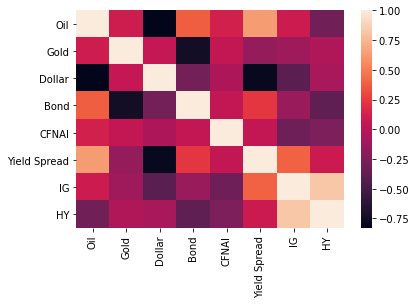

In [20]:
import seaborn as sns
sns.heatmap(df[['Oil','Gold','Dollar','Bond','CFNAI','Yield Spread','IG','HY']].corr(), annot = False, fmt='.1g')

In [21]:
features = ['Oil','Gold','Dollar','Bond','CFNAI','Yield Spread','IG','HY']
x = df[features]
y = df[tickers]

In [22]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)
print(tscv)
for train_index, test_index in tscv.split(x):
    # print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(x_train);
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
n_folds = 10
n_jobs = -1

## 1. OLS

In [93]:
def ols(x_train,y_train,x_test,y_test):
    reg = LinearRegression().fit(x_train, y_train)
    RMSE_test = np.sqrt(mean_squared_error(reg.predict(x_test), y_test))
    RMSE_train = np.sqrt(mean_squared_error(reg.predict(x_train), y_train))
    mean = np.mean(reg.predict(x_test))
    pred_train = reg.predict(x_train)
    pred_test = reg.predict(x_test)
    return reg.coef_,RMSE_test,RMSE_train,mean,pred_train,pred_test

In [94]:
for i in tickers:
    print(i+' Parameters:', ols(x_train,y_train[i],x_test,y_test[i])[0])
    print(i+' RMSE(test):', ols(x_train,y_train[i],x_test,y_test[i])[1])
    print(i+' RMSE(train):', ols(x_train,y_train[i],x_test,y_test[i])[2])
    print(i+' Mean:', ols(x_train,y_train[i],x_test,y_test[i])[3])
    print('='*80)

XLF Parameters: [-0.02813491  0.62299204  3.54267042  0.60325638 -0.09854405 -1.36777778
  0.42085387 -2.7638862 ]
XLF RMSE(test): 9.743989271429918
XLF RMSE(train): 1.474058890976732
XLF Mean: 24.45481092415875
XLE Parameters: [ 4.14894668 -4.4680412  -1.143657   -1.36711713 -0.16374103  0.06980619
 -0.20266285 -3.80812974]
XLE RMSE(test): 6.680178565092516
XLE RMSE(train): 2.7868761149763315
XLE Mean: 45.85225220950845
XLU Parameters: [ 2.15421366  0.33241361  8.28396373 -2.59132832 -0.22716655 -3.14823787
  1.5796429  -4.84193745]
XLU RMSE(test): 9.336188668426267
XLU RMSE(train): 2.8926006774132267
XLU Mean: 54.157474923761605
XLI Parameters: [ 0.77816007  0.92292489  9.87798458  0.40606658 -0.09660074 -3.9770234
  1.40264856 -7.53322772]
XLI RMSE(test): 26.357434428418006
XLI RMSE(train): 3.9228920343569063
XLI Mean: 68.25676484572138
XLK Parameters: [ 4.43077195  6.14426342 19.72418692 -0.86345096  0.62870378 -4.78321398
  5.86451634 -9.9531037 ]
XLK RMSE(test): 56.87640101193663

Text(0.5, 1.0, 'OLS(XLB)')

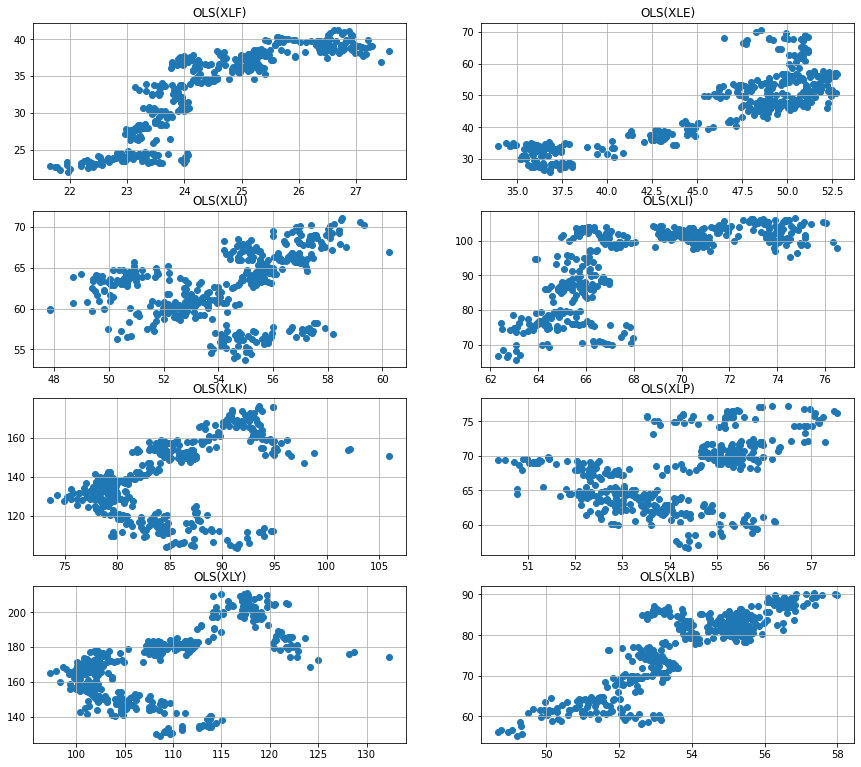

In [95]:
plt.subplots_adjust(left=0.1, bottom=0.5, top=3, right=2)

plt.subplot(421)
plt.scatter(ols(x_train,y_train.XLF,x_test,y_test.XLF)[5], y_test.XLF)
plt.grid();
plt.title("OLS(XLF)")

plt.subplot(422)
plt.scatter(ols(x_train,y_train.XLE,x_test,y_test.XLE)[5], y_test.XLE)
plt.grid();
plt.title("OLS(XLE)")

plt.subplot(423)
plt.scatter(ols(x_train,y_train.XLU,x_test,y_test.XLU)[5], y_test.XLU)
plt.grid();
plt.title("OLS(XLU)")

plt.subplot(424)
plt.scatter(ols(x_train,y_train.XLI,x_test,y_test.XLI)[5], y_test.XLI)
plt.grid();
plt.title("OLS(XLI)")

plt.subplot(425)
plt.scatter(ols(x_train,y_train.XLK,x_test,y_test.XLK)[5], y_test.XLK)
plt.grid();
plt.title("OLS(XLK)")

plt.subplot(426)
plt.scatter(ols(x_train,y_train.XLP,x_test,y_test.XLP)[5], y_test.XLP)
plt.grid();
plt.title("OLS(XLP)")

plt.subplot(427)
plt.scatter(ols(x_train,y_train.XLY,x_test,y_test.XLY)[5], y_test.XLY)
plt.grid();
plt.title("OLS(XLY)")

plt.subplot(428)
plt.scatter(ols(x_train,y_train.XLB,x_test,y_test.XLB)[5], y_test.XLB)
plt.grid();
plt.title("OLS(XLB)")

### Results

In [96]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()

for i in tickers:
    df1[i] = ols(x_train,y_train[i],x_test,y_test[i])[4]
    df2[i] = ols(x_train,y_train[i],x_test,y_test[i])[5]
    
ols = pd.concat([df1,df2],axis=0)
ols

,XLF,XLE,XLU,XLI,XLK,XLP,XLY,XLB
0,11.075986,50.748589,26.888311,32.043197,33.777034,27.139933,48.458215,30.535918
1,11.074697,50.662747,27.095451,32.121054,33.464601,27.467847,48.422016,30.607093
2,11.023491,50.662942,26.936597,31.971164,32.790215,27.436463,47.974570,30.396487
3,10.617506,50.371588,26.695191,31.078349,31.340881,27.389611,47.033040,29.657359
4,10.743695,50.518437,26.793376,31.359602,32.035800,27.397853,47.539760,29.856443
...,...,...,...,...,...,...,...,...
413,26.976843,47.689435,57.234302,74.547287,97.790965,53.807428,124.126584,55.099734
414,27.113313,47.553871,57.212933,74.818567,98.754743,53.658755,124.935149,55.352075
415,27.225729,46.458328,58.151374,75.260872,102.195083,54.227128,128.142123,55.417746
416,27.583566,48.281552,58.652357,76.335015,101.977955,54.597265,128.711675,56.493409


## 2.Ridge

In [104]:
def ridge(x_train,y_train,x_test,y_test):
    ridge = Ridge()
    alphas_ridge = np.linspace(1,500,500)
    parameters = {'alpha':alphas_ridge}
    gs_ridge = GridSearchCV(ridge,
                        parameters,
                        cv = n_folds,
                        refit=True,
                        n_jobs=n_jobs,
                        scoring='neg_mean_squared_error',
                        verbose = 10)

    gs = gs_ridge.fit(x_train,y_train)
    alpha_star = gs_ridge.best_params_
    MSE_val_ridge = pd.DataFrame(np.matrix([-gs_ridge.cv_results_['mean_test_score']]).T, columns = ["Ridge MSE values"])
    
    RMSE_test = np.sqrt(mean_squared_error(gs.predict(x_test), y_test))
    RMSE_train = np.sqrt(mean_squared_error(gs.predict(x_train), y_train))
    mean = np.mean(gs.predict(x_test))
    pred_train = gs.predict(x_train)
    pred_test = gs.predict(x_test)
    return alpha_star,RMSE_test,RMSE_train,mean,pred_train,pred_test,MSE_val_ridge,alphas_ridge

In [113]:
for i in tickers:
    result = ridge(x_train,y_train[i],x_test,y_test[i])
    print(i+' Parameters:', result[0])
    print(i+' RMSE(test):', result[1])
    print(i+' RMSE(train):', result[2])
    print(i+' Mean:', result[3])
    print('='*70)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLF Parameters: {'alpha': 189.0}
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLF RMSE(test): 11.033387159657144
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLF RMSE(train): 1.5757895381720055
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLF Mean: 23.134811342617972
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLE Parameters: {'alpha': 72.0}
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLE RMSE(test): 6.9572478752980125
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLE RMSE(train): 2.8356756534528023
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLE Mean: 46.943359932686064
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLU Parameters: {'alpha': 32.0}
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
XLU RMSE(test): 9.908673130685575
Fitting 10 folds fo

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


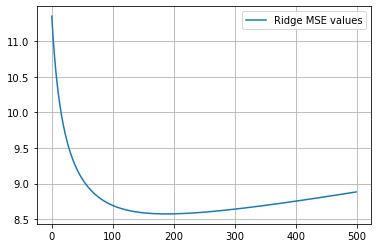

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


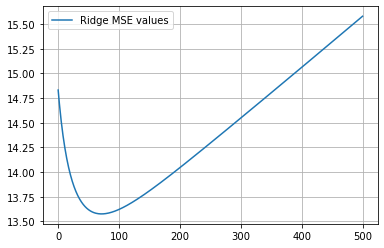

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


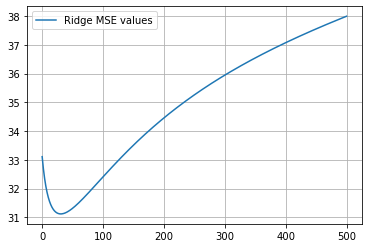

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


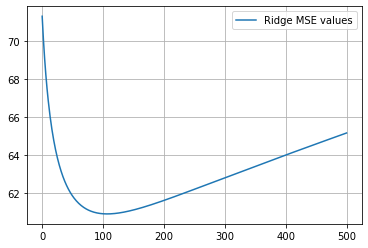

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


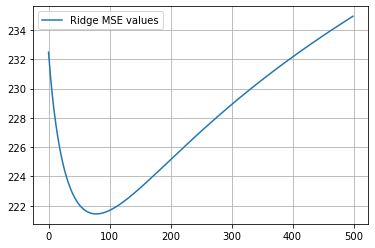

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


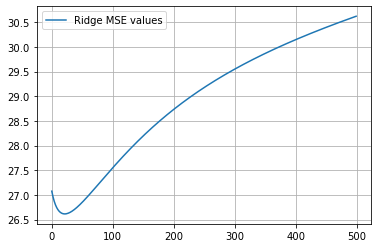

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


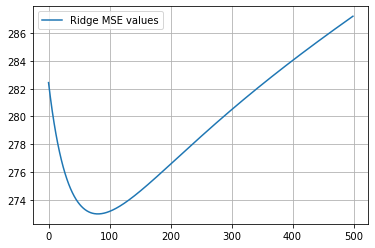

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


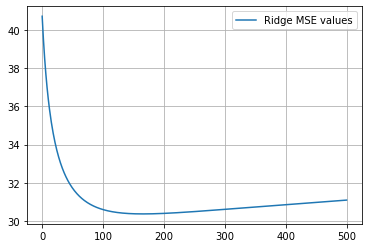

In [111]:
for i in tickers:
    result = ridge(x_train,y_train[i],x_test,y_test[i])
    MSE_val_ridge = result[6]
    alphas_ridge = result[7]
    MSE_val_ridge.set_axis(alphas_ridge, axis=0)
    MSE_val_ridge.plot()
    plt.grid(True)
    plt.title("Ridge_"+i)
    plt.show()

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


Text(0.5, 1.0, 'Ridge(XLB)')

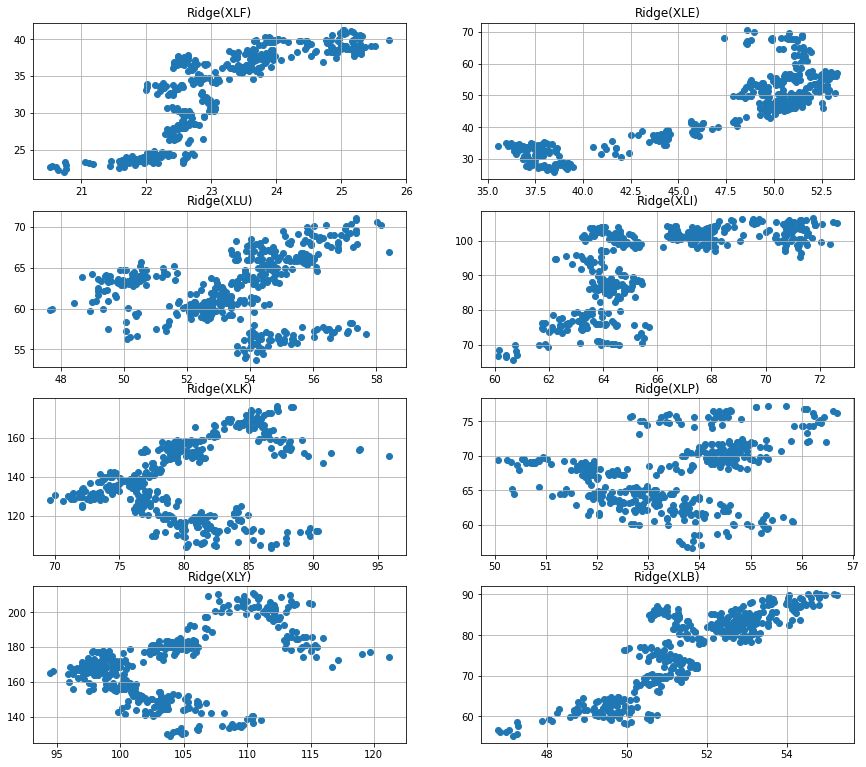

In [115]:
plt.subplots_adjust(left=0.1, bottom=0.5, top=3, right=2)

plt.subplot(421)
plt.scatter(ridge(x_train,y_train.XLF,x_test,y_test.XLF)[5], y_test.XLF)
plt.grid();
plt.title("Ridge(XLF)")

plt.subplot(422)
plt.scatter(ridge(x_train,y_train.XLE,x_test,y_test.XLE)[5], y_test.XLE)
plt.grid();
plt.title("Ridge(XLE)")

plt.subplot(423)
plt.scatter(ridge(x_train,y_train.XLU,x_test,y_test.XLU)[5], y_test.XLU)
plt.grid();
plt.title("Ridge(XLU)")

plt.subplot(424)
plt.scatter(ridge(x_train,y_train.XLI,x_test,y_test.XLI)[5], y_test.XLI)
plt.grid();
plt.title("Ridge(XLI)")

plt.subplot(425)
plt.scatter(ridge(x_train,y_train.XLK,x_test,y_test.XLK)[5], y_test.XLK)
plt.grid();
plt.title("Ridge(XLK)")

plt.subplot(426)
plt.scatter(ridge(x_train,y_train.XLP,x_test,y_test.XLP)[5], y_test.XLP)
plt.grid();
plt.title("Ridge(XLP)")

plt.subplot(427)
plt.scatter(ridge(x_train,y_train.XLY,x_test,y_test.XLY)[5], y_test.XLY)
plt.grid();
plt.title("Ridge(XLY)")

plt.subplot(428)
plt.scatter(ridge(x_train,y_train.XLB,x_test,y_test.XLB)[5], y_test.XLB)
plt.grid();
plt.title("Ridge(XLB)")

### Results

In [116]:
df3 = pd.DataFrame()
df4 = pd.DataFrame()

for i in tickers:
    result = ridge(x_train,y_train[i],x_test,y_test[i])
    df3[i] = result[4]
    df4[i] = result[5]
    
ridge = pd.concat([df3,df4],axis=0)
ridge

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Fitting 10 folds for each

,XLF,XLE,XLU,XLI,XLK,XLP,XLY,XLB
0,10.876456,51.172900,26.835440,31.731203,32.575723,27.146144,47.406316,30.505743
1,10.929785,51.029701,27.057458,31.893554,32.453588,27.486653,47.553906,30.629409
2,10.971493,51.036850,26.930574,31.913516,32.001654,27.466188,47.321760,30.618427
3,10.657874,50.583675,26.662093,31.120810,30.723050,27.413270,46.435920,30.033450
4,10.724860,50.774740,26.737467,31.303278,31.213993,27.401500,46.747647,30.154598
...,...,...,...,...,...,...,...,...
413,25.200134,48.573317,56.118962,71.283643,90.706873,52.965444,116.657984,53.148755
414,25.188518,48.520882,56.077676,71.319298,91.327956,52.812722,117.160078,53.136820
415,25.000178,47.388818,56.795143,71.140849,93.608876,53.248854,119.046925,52.762491
416,25.297147,48.948262,57.267224,72.060499,93.502703,53.645952,119.689079,53.524854


## 3.Lasso

In [122]:
def lasso(x_train,y_train,x_test,y_test):
    lasso = Lasso()
    alphas_lasso = np.linspace(0.01,1,200)
    parameters = {'alpha':alphas_lasso}
    gs_lasso = GridSearchCV(lasso,
                        parameters,
                        cv=n_folds,
                        refit = True,
                        n_jobs = n_jobs,
                        scoring = 'neg_mean_squared_error',
                        verbose = 10)

    la = gs_lasso.fit(x_train,y_train)
    alpha_star = gs_lasso.best_params_
    MSE_val_lasso = pd.DataFrame(np.matrix([-gs_lasso.cv_results_['mean_test_score']]).T, columns = ["Lasso MSE values"])

    RMSE_test = np.sqrt(mean_squared_error(la.predict(x_test), y_test))
    RMSE_train = np.sqrt(mean_squared_error(la.predict(x_train), y_train))
    mean = np.mean(la.predict(x_test))
    pred_train = la.predict(x_train)
    pred_test = la.predict(x_test)
    return alpha_star,RMSE_test,RMSE_train,mean,pred_train,pred_test,MSE_val_lasso,alphas_lasso

In [123]:
for i in tickers:
    result = lasso(x_train,y_train[i],x_test,y_test[i])
    print(i+' Parameters:', result[0])
    print(i+' RMSE(test):', result[1])
    print(i+' RMSE(train):', result[2])
    print(i+' Mean:', result[3])
    print('='*70)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLF Parameters: {'alpha': 0.2935678391959799}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLF RMSE(test): 10.948296238358962
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLF RMSE(train): 1.605711126383016
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLF Mean: 23.272441049726293
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLE Parameters: {'alpha': 0.1492964824120603}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLE RMSE(test): 6.857718382071169
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLE RMSE(train): 2.8673054080953566
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLE Mean: 46.856872333585734
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLU Parameters: {'alpha': 0.019949748743718593}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
XLU RMSE(tes

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


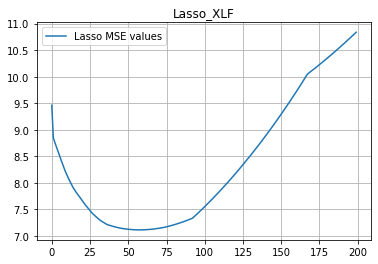

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


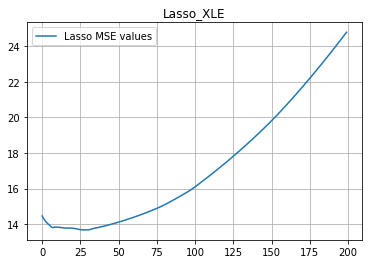

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


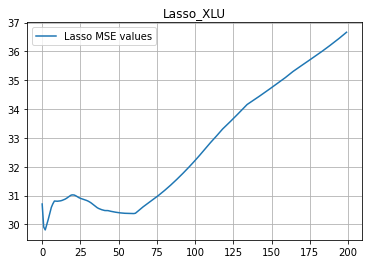

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


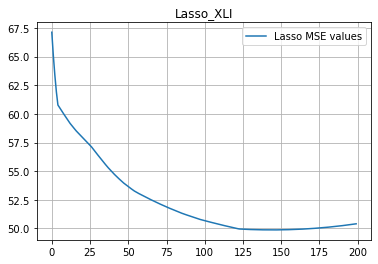

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


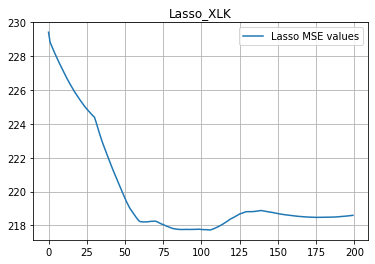

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


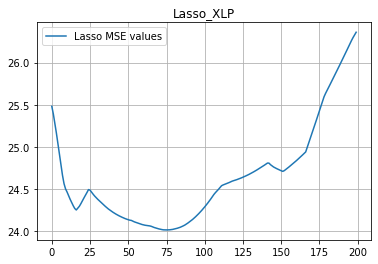

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


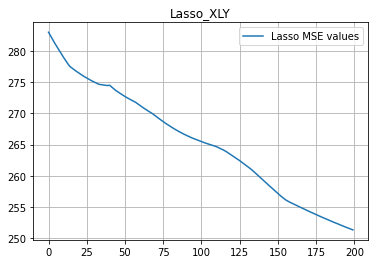

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


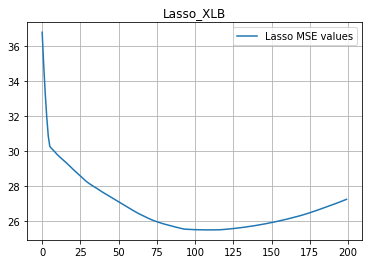

In [124]:
for i in tickers:
    result = lasso(x_train,y_train[i],x_test,y_test[i])
    MSE_val_lasso = result[6]
    alphas_lasso = result[7]
    MSE_val_lasso.set_axis(alphas_lasso, axis=0)
    MSE_val_lasso.plot()
    plt.grid(True)
    plt.title("Lasso_"+i)
    plt.show()

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


Text(0.5, 1.0, 'Lasso(XLB)')

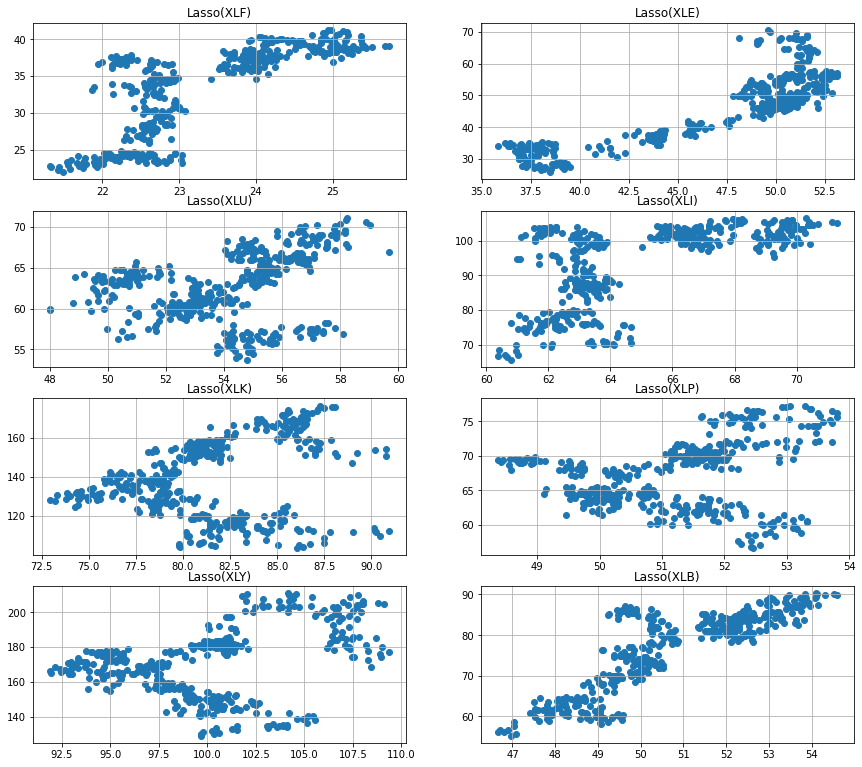

In [125]:
plt.subplots_adjust(left=0.1, bottom=0.5, top=3, right=2)

plt.subplot(421)
plt.scatter(lasso(x_train,y_train.XLF,x_test,y_test.XLF)[5], y_test.XLF)
plt.grid();
plt.title("Lasso(XLF)")

plt.subplot(422)
plt.scatter(lasso(x_train,y_train.XLE,x_test,y_test.XLE)[5], y_test.XLE)
plt.grid();
plt.title("Lasso(XLE)")

plt.subplot(423)
plt.scatter(lasso(x_train,y_train.XLU,x_test,y_test.XLU)[5], y_test.XLU)
plt.grid();
plt.title("Lasso(XLU)")

plt.subplot(424)
plt.scatter(lasso(x_train,y_train.XLI,x_test,y_test.XLI)[5], y_test.XLI)
plt.grid();
plt.title("Lasso(XLI)")

plt.subplot(425)
plt.scatter(lasso(x_train,y_train.XLK,x_test,y_test.XLK)[5], y_test.XLK)
plt.grid();
plt.title("Lasso(XLK)")

plt.subplot(426)
plt.scatter(lasso(x_train,y_train.XLP,x_test,y_test.XLP)[5], y_test.XLP)
plt.grid();
plt.title("Lasso(XLP)")

plt.subplot(427)
plt.scatter(lasso(x_train,y_train.XLY,x_test,y_test.XLY)[5], y_test.XLY)
plt.grid();
plt.title("Lasso(XLY)")

plt.subplot(428)
plt.scatter(lasso(x_train,y_train.XLB,x_test,y_test.XLB)[5], y_test.XLB)
plt.grid();
plt.title("Lasso(XLB)")

### Results

In [126]:
df5 = pd.DataFrame()
df6 = pd.DataFrame()

for i in tickers:
    df5[i] = lasso(x_train,y_train[i],x_test,y_test[i])[4]
    df6[i] = lasso(x_train,y_train[i],x_test,y_test[i])[5]
    
lasso = pd.concat([df5,df6],axis=0)
lasso

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each

,XLF,XLE,XLU,XLI,XLK,XLP,XLY,XLB
0,10.882990,51.634039,26.827093,31.718147,30.227140,28.213088,43.643298,31.100716
1,10.966510,51.452659,27.036360,31.957579,30.223495,28.489606,44.110410,31.209646
2,10.973022,51.413212,26.891230,31.989377,30.002140,28.530093,44.262469,31.192397
3,10.729658,50.942863,26.634384,31.411143,28.675042,28.568555,43.792154,30.724292
4,10.780595,51.148297,26.728995,31.525577,29.129058,28.541770,43.856122,30.839882
...,...,...,...,...,...,...,...,...
413,24.905598,49.056556,56.969834,69.285850,88.965738,51.839505,108.442560,52.776275
414,24.887333,49.118001,56.942091,69.226357,89.220910,51.757875,108.264558,52.782832
415,24.802951,48.153765,57.812780,69.076130,90.784705,52.265506,108.925078,52.617563
416,25.215084,49.722857,58.279404,70.088710,90.215475,52.360985,109.388992,53.340735


## 4.XGBoost

In [134]:
def xg(x_train,y_train,x_test,y_test):
    model = xgb.XGBRegressor()
    n_estimators = [100, 500, 900, 1100, 1500]
    max_depth = np.arange(1,16,1)
    learning_rate= np.arange(0,1,0.01)
    min_child_weight= [1,2,3,4]
    alpha = np.arange(0,1,0.01)
    
    hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'reg_alpha' : alpha}
    
    random_cv = RandomizedSearchCV(estimator=model,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

    random_cv.fit(x_train,y_train)
    alpha_star = random_cv.best_estimator_
    
    MSE_val_xg = pd.DataFrame(np.matrix([-random_cv.cv_results_['mean_test_score']]).T, columns = ["XGBoost MSE values"])
    
    params = {'n_estimators': 1100, "objective":"reg:squarederror",'colsample_bytree': 1,'learning_rate': 0.86,'max_depth': 2, 'alpha': 0.84}
    xg = xgb.XGBRegressor(**params)
    xg.fit(x_train,y_train)
    
    RMSE_test = np.sqrt(mean_squared_error(xg.predict(x_test), y_test))
    RMSE_train = np.sqrt(mean_squared_error(xg.predict(x_train), y_train))
    mean = np.mean(xg.predict(x_test))
    pred_train = xg.predict(x_train)
    pred_test = xg.predict(x_test)
    
    score = r2_score(y_test, xg.predict(x_test))
    
    return alpha_star,RMSE_test,RMSE_train,mean,pred_train,pred_test,MSE_val_xg,alpha,score

In [138]:
for i in tickers:
    result = xg(x_train,y_train[i],x_test,y_test[i])
    print(i+' Parameters:', result[0])
    print(i+' RMSE(test):', result[1])
    print(i+' RMSE(train):', result[2])
    print(i+' Mean:', result[3])
    print(i+' Score:', result[8])
    print('='*70)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XLF Parameters: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.75, max_delta_step=0,
             max_depth=2, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=1100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.8200000000000001, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
XLF RMSE(test): 13.470273370575137
XLF RMSE(train): 0.14921350402664457
XLF Mean: 21.552296
XLF Score: -4.099147427071011
Fitting 5 folds for each of 50 candidates, totalling 250 fits
XLE Parameters: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 

### Results

In [141]:
df7 = pd.DataFrame()
df8 = pd.DataFrame()

for i in tickers:
    result = xg(x_train,y_train[i],x_test,y_test[i])
    df7[i] = result[4]
    df8[i] = result[5]
    
xg = pd.concat([df7,df8],axis=0)
xg

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


,XLF,XLE,XLU,XLI,XLK,XLP,XLY,XLB
0,10.036815,52.144474,24.757072,30.394989,24.966196,25.543779,38.201199,30.013145
1,9.911898,51.793091,24.574705,30.150959,24.923407,25.497646,38.206146,29.560810
2,9.759398,51.262566,24.484449,29.870836,24.758760,25.077969,37.643948,29.517899
3,9.941820,51.369568,24.494596,29.652802,24.508957,25.153112,38.049801,29.436617
4,9.914973,51.555954,24.715755,30.255445,24.846174,25.450052,38.264915,29.875452
...,...,...,...,...,...,...,...,...
413,26.529203,57.958893,56.889671,75.610962,94.121712,58.203251,127.465569,57.436817
414,26.764351,59.479805,56.477936,75.649635,93.442986,58.275780,128.571686,57.514652
415,26.199970,59.010880,55.185471,70.719566,90.967941,58.848999,123.977356,55.896065
416,25.167183,61.515785,57.170296,72.506660,94.513191,58.575283,127.219421,57.220619


## Calculation Part

In [395]:
riskFree = web.get_data_yahoo('GOVT',start,end,interval='d')['Adj Close']
riskFree = pd.DataFrame([riskFree]).T
riskFree.columns = ['Risk Free']
riskFree

,Risk Free
Date,
2012-03-01,21.551907
2012-03-02,21.551907
2012-03-05,21.551907
2012-03-06,21.551907
2012-03-07,21.621391
...,...
2022-02-23,25.461611
2022-02-24,25.471592
2022-02-25,25.511515


### (1)OLS

In [485]:
returns = ['F','E','U','I','K','P','Y','B']
ols.columns = returns
OLS = pd.concat([df,riskFree],axis=1)
OLS = OLS.dropna(axis=0, how='any')

In [486]:
OLS = OLS.reset_index()
ols = ols.reset_index()
ols = ols[['F','E','U','I','K','P','Y','B']]
OLS = pd.concat([OLS,ols],axis=1)

In [487]:
for i in returns:
    OLS['RET_'+i] = np.log(OLS['XL'+i]) - np.log(OLS['XL'+i].shift(1))
    OLS['ret_'+i] = np.log(OLS[i]) - np.log(OLS[i].shift(1))
    
OLS['Rf'] = np.log(OLS['Risk Free']) - np.log(OLS['Risk Free'].shift(1))

In [488]:
OLS['month'] = pd.to_datetime(OLS['index']).dt.month
OLS['year'] = pd.to_datetime(OLS['index']).dt.year
df_ols = OLS.groupby(['year','month'],as_index=False).mean()
df_ols

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,ret_I,RET_K,ret_K,RET_P,ret_P,RET_Y,ret_Y,RET_B,ret_B,Rf
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.002039,0.002392,-0.009282,0.001859,-0.001379,0.001961,-0.005522,0.000436,-0.001213,-0.000366
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.001235,-0.000927,0.005014,-0.000117,0.002226,0.000768,0.003923,-0.000807,0.000611,0.000636
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.000584,-0.004332,0.003013,-0.001497,0.003932,-0.004328,0.004095,-0.004928,-0.000286,0.000903
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0.001643,0.003055,-0.002817,0.002858,-0.000458,0.002581,-0.002448,0.003065,0.001987,-0.000246
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.001318,0.000443,0.000731,0.000649,0.001970,-0.000600,0.000866,-0.000354,0.000837,0.000469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,0.000935,0.002960,0.002136,0.001588,0.000049,0.005945,0.001828,0.002846,0.000409,-0.000034
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,-0.000741,0.001488,-0.000957,-0.000950,0.000089,-0.000960,-0.000818,-0.000862,-0.000633,0.000289
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.002277,0.002509,0.002733,0.004734,0.000794,0.002183,0.002177,0.003191,0.001780,0.000164
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.000839,-0.003888,-0.000059,-0.000784,-0.001497,-0.006123,0.000658,-0.002101,-0.002029,-0.001329


In [489]:
t1 = df_ols[['RET_F','RET_E','RET_U','RET_I','RET_K','RET_P','RET_Y','RET_B','ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B','Rf']]
t1 = t1.T

In [490]:
index_1 = []
index_2 = []

for i in range(120):
    index_1.append(t1.iloc[8:16,i].nlargest(3).index)
    index_2.append(t1.iloc[8:16,i].nsmallest(3).index)

test_1 = np.array(list(index_1))
test_2 = np.array(list(index_2))

In [491]:
test_1

array([['ret_E', 'ret_F', 'ret_B'],
       ['ret_K', 'ret_U', 'ret_Y'],
       ['ret_U', 'ret_Y', 'ret_P'],
       ['ret_F', 'ret_B', 'ret_I'],
       ['ret_U', 'ret_P', 'ret_E'],
       ['ret_K', 'ret_F', 'ret_Y'],
       ['ret_F', 'ret_B', 'ret_I'],
       ['ret_E', 'ret_F', 'ret_B'],
       ['ret_K', 'ret_Y', 'ret_U'],
       ['ret_E', 'ret_F', 'ret_I'],
       ['ret_F', 'ret_E', 'ret_I'],
       ['ret_U', 'ret_Y', 'ret_P'],
       ['ret_K', 'ret_Y', 'ret_U'],
       ['ret_E', 'ret_U', 'ret_P'],
       ['ret_F', 'ret_E', 'ret_Y'],
       ['ret_E', 'ret_Y', 'ret_P'],
       ['ret_K', 'ret_F', 'ret_Y'],
       ['ret_K', 'ret_Y', 'ret_F'],
       ['ret_E', 'ret_P', 'ret_B'],
       ['ret_F', 'ret_I', 'ret_B'],
       ['ret_E', 'ret_B', 'ret_F'],
       ['ret_E', 'ret_F', 'ret_I'],
       ['ret_K', 'ret_U', 'ret_Y'],
       ['ret_K', 'ret_F', 'ret_I'],
       ['ret_E', 'ret_F', 'ret_I'],
       ['ret_K', 'ret_U', 'ret_B'],
       ['ret_E', 'ret_P', 'ret_U'],
       ['ret_K', 'ret_F', 'r

In [494]:
df_ols['w_F'] = [0]*len(df_ols)
df_ols['w_E'] = [0]*len(df_ols)
df_ols['w_U'] = [0]*len(df_ols)
df_ols['w_I'] = [0]*len(df_ols)
df_ols['w_K'] = [0]*len(df_ols)
df_ols['w_P'] = [0]*len(df_ols)
df_ols['w_Y'] = [0]*len(df_ols)
df_ols['w_B'] = [0]*len(df_ols)

list_1 = ['ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B']

for j in range(120):
    for i in list_1:
        if i in test_1[j]:
            df_ols['w_'+i[-1]].loc[j] = 1/3
        elif i in test_2[j]:
            df_ols['w_'+i[-1]].loc[j] = -1/3
        else:
            df_ols['w_'+i[-1]].loc[j] = 0
            
df_ols['Portfolio Return'] = df_ols['ret_F']*df_ols['w_F']+df_ols['ret_E']*df_ols['w_E']+df_ols['ret_U']*df_ols['w_U']+df_ols['ret_I']*df_ols['w_I']+df_ols['ret_K']*df_ols['w_K']+df_ols['ret_P']*df_ols['w_P']+df_ols['ret_Y']*df_ols['w_Y']+df_ols['ret_B']*df_ols['w_B']
df_ols

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,Rf,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.000366,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.005706
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.000636,-0.333333,-0.333333,0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,0.004220
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.000903,-0.333333,-0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,-0.333333,0.005661
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,-0.000246,0.333333,0.000000,-0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.004314
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.000469,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.001084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,-0.000034,-0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.001279
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,0.000289,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.333333,-0.333333,0.333333,0.001737
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.000164,0.333333,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.001041
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.001329,-0.333333,0.333333,0.000000,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.001965


In [493]:
df_ols[['year','month','w_F','w_E','w_U','w_I','w_K','w_P','w_Y','w_B','Portfolio Return']]

,year,month,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return
0,2012,3,1,1,-1,0,-1,0,-1,1,0.017119
1,2012,4,-1,-1,1,0,1,0,1,-1,0.012661
2,2012,5,-1,-1,1,0,0,1,1,-1,0.016983
3,2012,6,1,0,-1,1,-1,0,-1,1,0.012942
4,2012,7,-1,1,1,0,-1,1,0,-1,0.003253
...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,-1,0,1,0,1,-1,1,-1,0.003838
116,2021,11,0,-1,1,0,-1,1,-1,1,0.005211
117,2021,12,1,0,-1,1,1,-1,0,-1,0.003122
118,2022,1,-1,1,0,0,1,-1,1,-1,0.005894


In [495]:
in_1 = df_ols.loc[:99]
out_1 = df_ols.loc[100:]

In [496]:
corr = in_1.corr().iloc[10:18,10:18]

sf = np.std(in_1['RET_F'])
se = np.std(in_1['RET_E'])
su = np.std(in_1['RET_U'])
si = np.std(in_1['RET_I'])
sk = np.std(in_1['RET_K'])
sp = np.std(in_1['RET_P'])
sy = np.std(in_1['RET_Y'])
sb = np.std(in_1['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [497]:
wf = in_1['w_F']
we = in_1['w_E']
wu = in_1['w_U']
wi = in_1['w_I']
wk = in_1['w_K']
wp = in_1['w_P'] 
wy = in_1['w_Y']
wb = in_1['w_B']

in_1['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
in_1

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.005706,4.016665e-06
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,-0.333333,-0.333333,0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,0.004220,4.016665e-06
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,-0.333333,-0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,-0.333333,0.005661,3.454894e-06
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0.333333,0.000000,-0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.004314,7.771900e-07
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.001084,3.305198e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020,2,50.542632,1595.615780,116.707774,1.504211,0.08,0.173158,1.567895,3.881053,...,-0.333333,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.333333,0.000000,0.002966,3.156760e-06
96,2020,3,29.207727,1594.650008,121.034782,0.870000,-4.29,0.421818,2.882727,7.854091,...,-0.333333,-0.333333,0.333333,-0.333333,0.333333,0.000000,0.333333,0.000000,0.011591,3.706497e-06
97,2020,4,16.547619,1694.980940,123.354167,0.657619,-17.84,0.432857,3.508571,8.138095,...,0.333333,0.000000,-0.333333,0.333333,-0.333333,0.333333,-0.333333,0.000000,0.005047,3.848336e-07
98,2020,5,28.562500,1718.690015,122.634380,0.674000,4.62,0.503500,2.811000,7.336000,...,-0.333333,0.333333,-0.333333,0.000000,0.333333,-0.333333,0.333333,0.000000,0.006348,2.168262e-06


In [498]:
corr = out_1.corr().iloc[10:18,10:18]

sf = np.std(out_1['RET_F'])
se = np.std(out_1['RET_E'])
su = np.std(out_1['RET_U'])
si = np.std(out_1['RET_I'])
sk = np.std(out_1['RET_K'])
sp = np.std(out_1['RET_P'])
sy = np.std(out_1['RET_Y'])
sb = np.std(out_1['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [499]:
wf = out_1['w_F']
we = out_1['w_E']
wu = out_1['w_U']
wi = out_1['w_I']
wk = out_1['w_K']
wp = out_1['w_P'] 
wy = out_1['w_Y']
wb = out_1['w_B']

out_1['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
out_1

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
100,2020,7,40.710455,1847.540905,118.711991,0.623636,2.60,0.475455,2.204545,5.678182,...,0.333333,-0.333333,0.000000,0.333333,0.000000,-0.333333,-0.333333,0.333333,0.002881,1.091287e-06
101,2020,8,42.339048,1966.238084,116.971381,0.650000,1.21,0.510476,1.939524,5.123810,...,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.002144,1.803267e-06
102,2020,9,39.634286,1920.276187,116.363043,0.679524,0.37,0.544762,1.923333,5.266190,...,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.001581,6.785930e-07
103,2020,10,39.395909,1900.245450,115.772309,0.787273,1.07,0.637273,1.863636,5.040000,...,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.001888,1.803267e-06
104,2020,11,41.169500,1866.079999,114.059895,0.875500,0.24,0.708500,1.753500,4.535000,...,0.000000,0.333333,0.000000,0.333333,-0.333333,-0.333333,-0.333333,0.333333,0.004392,1.346542e-06
105,2020,12,47.025000,1859.295443,111.913445,0.933636,0.36,0.797727,1.639091,4.044545,...,0.333333,-0.333333,-0.333333,0.000000,0.333333,-0.333333,0.000000,0.333333,0.001931,6.785930e-07
106,2021,1,52.008421,1865.184217,111.491000,1.081053,1.23,0.950000,1.591053,3.780000,...,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,-0.333333,0.000000,0.001272,1.553241e-06
107,2021,2,59.046316,1805.531584,112.020053,1.257895,-1.60,1.142632,1.478421,3.526842,...,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,-0.333333,0.000000,0.003498,1.553241e-06
108,2021,3,62.333043,1719.517392,113.354722,1.610870,2.31,1.463913,1.470000,3.547391,...,0.000000,-0.333333,-0.333333,0.000000,0.333333,-0.333333,0.333333,0.333333,0.001689,1.001994e-06
109,2021,4,61.716667,1759.757144,112.608033,1.630952,-0.07,1.469048,1.542857,3.268095,...,0.000000,0.333333,0.333333,0.000000,0.333333,-0.333333,-0.333333,-0.333333,0.000705,1.085728e-06


### Results of OLS (monthly)

In [500]:
in_annual_return_1 = 12/100 * in_1['Portfolio Return'].sum()
out_annual_return_1 = 12/20 * out_1['Portfolio Return'].sum()

print('Annualized return (in sample):', in_annual_return_1)
print('Annualized return (out of sample):', out_annual_return_1)
print('='*70)

in_annual_risk_1 = ((12/100)*in_1['var'].sum())**0.5
out_annual_risk_1 = ((12/20)*out_1['var'].sum())**0.5

print('Annualized risk (in sample):', in_annual_risk_1)
print('Annualized risk (out of sample):', out_annual_risk_1)
print('='*70)

sharpe_OLS_in = (in_annual_return_1-in_1['Rf'].mean())/in_annual_risk_1
sharpe_OLS_out = (out_annual_return_1-out_1['Rf'].mean())/out_annual_risk_1

print('In sample sharpe ratio by OLS:', sharpe_OLS_in)
print('Out of sample sharpe ratio by OLS:', sharpe_OLS_out)
print('='*70)

Annualized return (in sample): 0.033301681775780904
Annualized return (out of sample): 0.024716536060065984
Annualized risk (in sample): 0.00618896485891164
Annualized risk (out of sample): 0.003946765408394196
In sample sharpe ratio by OLS: 5.363045058856886
Out of sample sharpe ratio by OLS: 6.29915217955923


In [510]:
RMSE_ols = []
for i in returns:
    RMSE_ols.append(np.sqrt(mean_squared_error(df_ols['RET_'+i], df_ols['ret_'+i])))

RMSE_ols = pd.DataFrame(RMSE_ols)
RMSE_ols = RMSE_ols.T
RMSE_ols.columns = returns
RMSE_ols

,F,E,U,I,K,P,Y,B
0,0.00246,0.002688,0.002681,0.002334,0.005195,0.002064,0.003607,0.002015


### (2)Ridge

In [511]:
returns = ['F','E','U','I','K','P','Y','B']
ridge.columns = returns
Ridge = pd.concat([df,riskFree],axis=1)
Ridge = Ridge.dropna(axis=0, how='any')

In [512]:
Ridge = Ridge.reset_index()
ridge = ridge.reset_index()
ridge = ridge[['F','E','U','I','K','P','Y','B']]
Ridge = pd.concat([Ridge,ridge],axis=1)

In [513]:
for i in returns:
    Ridge['RET_'+i] = np.log(Ridge['XL'+i]) - np.log(Ridge['XL'+i].shift(1))
    Ridge['ret_'+i] = np.log(Ridge[i]) - np.log(Ridge[i].shift(1))
    
Ridge['Rf'] = np.log(Ridge['Risk Free']) - np.log(Ridge['Risk Free'].shift(1))

In [514]:
Ridge['month'] = pd.to_datetime(Ridge['index']).dt.month
Ridge['year'] = pd.to_datetime(Ridge['index']).dt.year
df_ridge = Ridge.groupby(['year','month'],as_index=False).mean()
df_ridge

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,ret_I,RET_K,ret_K,RET_P,ret_P,RET_Y,ret_Y,RET_B,ret_B,Rf
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.000542,0.002392,-0.007260,0.001859,-0.001075,0.001961,-0.003648,0.000436,0.000066,-0.000366
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.000363,-0.000927,0.004046,-0.000117,0.001967,0.000768,0.002675,-0.000807,-0.000030,0.000636
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.000266,-0.004332,0.003350,-0.001497,0.003945,-0.004328,0.003946,-0.004928,-0.000699,0.000903
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0.002889,0.003055,-0.000459,0.002858,-0.000079,0.002581,-0.000405,0.003065,0.002670,-0.000246
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.001443,0.000443,0.000878,0.000649,0.001812,-0.000600,0.000750,-0.000354,0.001176,0.000469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,0.000633,0.002960,0.001803,0.001588,-0.000050,0.005945,0.001405,0.002846,0.000226,-0.000034
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,-0.000184,0.001488,-0.000074,-0.000950,0.000344,-0.000960,0.000064,-0.000862,-0.000272,0.000289
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.002104,0.002509,0.002573,0.004734,0.000737,0.002183,0.001973,0.003191,0.001617,0.000164
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.001022,-0.003888,-0.000585,-0.000784,-0.001688,-0.006123,0.000015,-0.002101,-0.001621,-0.001329


In [515]:
t2 = df_ridge[['RET_F','RET_E','RET_U','RET_I','RET_K','RET_P','RET_Y','RET_B','ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B','Rf']]
t2 = t2.T

In [516]:
index_3 = []
index_4 = []

for i in range(120):
    index_3.append(t2.iloc[9:,i].nlargest(3).index)
    index_4.append(t2.iloc[9:,i].nsmallest(3).index)

test_3 = np.array(list(index_3))
test_4 = np.array(list(index_4))

In [517]:
df_ridge['w_F'] = [0]*len(df_ridge)
df_ridge['w_E'] = [0]*len(df_ridge)
df_ridge['w_U'] = [0]*len(df_ridge)
df_ridge['w_I'] = [0]*len(df_ridge)
df_ridge['w_K'] = [0]*len(df_ridge)
df_ridge['w_P'] = [0]*len(df_ridge)
df_ridge['w_Y'] = [0]*len(df_ridge)
df_ridge['w_B'] = [0]*len(df_ridge)

list_1 = ['ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B']

for j in range(120):
    for i in list_1:
        if i in test_3[j]:
            df_ridge['w_'+i[-1]].loc[j] = 1/3
        elif i in test_4[j]:
            df_ridge['w_'+i[-1]].loc[j] = -1/3
        else:
            df_ridge['w_'+i[-1]].loc[j] = 0
            
df_ridge['Portfolio Return'] = df_ridge['ret_F']*df_ridge['w_F']+df_ridge['ret_E']*df_ridge['w_E']+df_ridge['ret_U']*df_ridge['w_U']+df_ridge['ret_I']*df_ridge['w_I']+df_ridge['ret_K']*df_ridge['w_K']+df_ridge['ret_P']*df_ridge['w_P']+df_ridge['ret_Y']*df_ridge['w_Y']+df_ridge['ret_B']*df_ridge['w_B']
df_ridge

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,Rf,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.000366,0,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.005151
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.000636,0,-0.333333,0.333333,-0.333333,0.333333,0.000000,0.333333,-0.333333,0.003520
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.000903,0,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.333333,-0.333333,0.005480
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,-0.000246,0,0.333333,-0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.002703
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.000469,0,0.000000,0.333333,0.333333,-0.333333,0.333333,-0.333333,0.000000,0.001220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,-0.000034,0,0.000000,0.333333,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.001316
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,0.000289,0,-0.333333,0.000000,-0.333333,0.000000,0.333333,0.333333,-0.333333,0.001603
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.000164,0,0.000000,0.000000,0.333333,0.333333,-0.333333,0.333333,-0.333333,0.001432
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.001329,0,0.333333,0.000000,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.001051


In [518]:
in_2 = df_ridge.loc[:99]
out_2 = df_ridge.loc[100:]

In [519]:
corr = in_2.corr().iloc[10:18,10:18]

sf = np.std(in_2['RET_F'])
se = np.std(in_2['RET_E'])
su = np.std(in_2['RET_U'])
si = np.std(in_2['RET_I'])
sk = np.std(in_2['RET_K'])
sp = np.std(in_2['RET_P'])
sy = np.std(in_2['RET_Y'])
sb = np.std(in_2['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [520]:
wf = in_2['w_F']
we = in_2['w_E']
wu = in_2['w_U']
wi = in_2['w_I']
wk = in_2['w_K']
wp = in_2['w_P'] 
wy = in_2['w_Y']
wb = in_2['w_B']

in_2['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
in_2

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,0,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.005151,5.791959e-06
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0,-0.333333,0.333333,-0.333333,0.333333,0.000000,0.333333,-0.333333,0.003520,4.075294e-06
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.333333,-0.333333,0.005480,3.459566e-06
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0,0.333333,-0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.002703,4.075294e-06
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0,0.000000,0.333333,0.333333,-0.333333,0.333333,-0.333333,0.000000,0.001220,4.291115e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020,2,50.542632,1595.615780,116.707774,1.504211,0.08,0.173158,1.567895,3.881053,...,0,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.000000,-0.333333,0.003257,2.947166e-06
96,2020,3,29.207727,1594.650008,121.034782,0.870000,-4.29,0.421818,2.882727,7.854091,...,0,-0.333333,0.000000,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.012545,3.000420e-06
97,2020,4,16.547619,1694.980940,123.354167,0.657619,-17.84,0.432857,3.508571,8.138095,...,0,0.000000,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.333333,0.005158,6.869291e-07
98,2020,5,28.562500,1718.690015,122.634380,0.674000,4.62,0.503500,2.811000,7.336000,...,0,0.333333,-0.333333,0.000000,0.333333,-0.333333,0.333333,0.000000,0.005214,1.702520e-06


In [521]:
corr = out_2.corr().iloc[10:18,10:18]

sf = np.std(out_2['RET_F'])
se = np.std(out_2['RET_E'])
su = np.std(out_2['RET_U'])
si = np.std(out_2['RET_I'])
sk = np.std(out_2['RET_K'])
sp = np.std(out_2['RET_P'])
sy = np.std(out_2['RET_Y'])
sb = np.std(out_2['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [522]:
wf = out_2['w_F']
we = out_2['w_E']
wu = out_2['w_U']
wi = out_2['w_I']
wk = out_2['w_K']
wp = out_2['w_P'] 
wy = out_2['w_Y']
wb = out_2['w_B']

out_2['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
out_2

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
100,2020,7,40.710455,1847.540905,118.711991,0.623636,2.60,0.475455,2.204545,5.678182,...,0,-0.333333,0.000000,0.333333,0.333333,-0.333333,0.000000,0.333333,0.002866,9.418748e-07
101,2020,8,42.339048,1966.238084,116.971381,0.650000,1.21,0.510476,1.939524,5.123810,...,0,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.002327,1.101115e-06
102,2020,9,39.634286,1920.276187,116.363043,0.679524,0.37,0.544762,1.923333,5.266190,...,0,0.333333,0.000000,-0.333333,-0.333333,0.333333,-0.333333,0.000000,0.001233,1.265676e-06
103,2020,10,39.395909,1900.245450,115.772309,0.787273,1.07,0.637273,1.863636,5.040000,...,0,0.333333,-0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.001763,1.478398e-06
104,2020,11,41.169500,1866.079999,114.059895,0.875500,0.24,0.708500,1.753500,4.535000,...,0,0.333333,0.000000,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.003989,2.405348e-06
105,2020,12,47.025000,1859.295443,111.913445,0.933636,0.36,0.797727,1.639091,4.044545,...,0,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000000,0.333333,0.001222,1.637832e-06
106,2021,1,52.008421,1865.184217,111.491000,1.081053,1.23,0.950000,1.591053,3.780000,...,0,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.001701,1.101115e-06
107,2021,2,59.046316,1805.531584,112.020053,1.257895,-1.60,1.142632,1.478421,3.526842,...,0,0.333333,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.000000,0.003325,2.004683e-06
108,2021,3,62.333043,1719.517392,113.354722,1.610870,2.31,1.463913,1.470000,3.547391,...,0,0.333333,-0.333333,0.000000,0.000000,-0.333333,0.333333,0.333333,0.000970,4.268633e-06
109,2021,4,61.716667,1759.757144,112.608033,1.630952,-0.07,1.469048,1.542857,3.268095,...,0,-0.333333,0.333333,0.000000,0.333333,-0.333333,0.000000,-0.333333,0.000703,2.484927e-06


### Results of Ridge (monthly)

In [523]:
in_annual_return_2 = 12/100 * in_2['Portfolio Return'].sum()
out_annual_return_2 = 12/20 * out_2['Portfolio Return'].sum()

print('Annualized return (in sample):', in_annual_return_2)
print('Annualized return (out of sample):', out_annual_return_2)
print('='*70)

in_annual_risk_2 = ((12/100)*in_2['var'].sum())**0.5
out_annual_risk_2 = ((12/20)*out_2['var'].sum())**0.5

print('Annualized risk (in sample):', in_annual_risk_2)
print('Annualized risk (out of sample):', out_annual_risk_2)
print('='*70)

sharpe_Ridge_in = (in_annual_return_2-in_2['Rf'].mean())/in_annual_risk_2
sharpe_Ridge_out = (out_annual_return_2-out_2['Rf'].mean())/out_annual_risk_2

print('In sample sharpe ratio by Ridge:', sharpe_Ridge_in)
print('Out of sample sharpe ratio by Ridge:', sharpe_Ridge_out)
print('='*70)

Annualized return (in sample): 0.031857786849657205
Annualized return (out of sample): 0.022642144775656035
Annualized risk (in sample): 0.006749916520325222
Annualized risk (out of sample): 0.004902310895233272
In sample sharpe ratio by Ridge: 4.703436314257056
Out of sample sharpe ratio by Ridge: 4.6481924804569195


In [524]:
RMSE_ridge = []
for i in returns:
    RMSE_ridge.append(np.sqrt(mean_squared_error(df_ridge['RET_'+i], df_ridge['ret_'+i])))

RMSE_ridge = pd.DataFrame(RMSE_ridge)
RMSE_ridge = RMSE_ridge.T
RMSE_ridge.columns = returns
RMSE_ridge

,F,E,U,I,K,P,Y,B
0,0.002274,0.002618,0.002512,0.002134,0.004506,0.001991,0.003084,0.001815


## (3)Lasso

In [525]:
returns = ['F','E','U','I','K','P','Y','B']
lasso.columns = returns
Lasso = pd.concat([df,riskFree],axis=1)
Lasso = Lasso.dropna(axis=0, how='any')

In [526]:
Lasso = Lasso.reset_index()
lasso = lasso.reset_index()
lasso = lasso[['F','E','U','I','K','P','Y','B']]
Lasso = pd.concat([Lasso,lasso],axis=1)

In [527]:
for i in returns:
    Lasso['RET_'+i] = np.log(Lasso['XL'+i]) - np.log(Lasso['XL'+i].shift(1))
    Lasso['ret_'+i] = np.log(Lasso[i]) - np.log(Lasso[i].shift(1))
    
Lasso['Rf'] = np.log(Lasso['Risk Free']) - np.log(Lasso['Risk Free'].shift(1))

In [528]:
Lasso['month'] = pd.to_datetime(Lasso['index']).dt.month
Lasso['year'] = pd.to_datetime(Lasso['index']).dt.year
df_lasso = Lasso.groupby(['year','month'],as_index=False).mean()
df_lasso

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,ret_I,RET_K,ret_K,RET_P,ret_P,RET_Y,ret_Y,RET_B,ret_B,Rf
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.000894,0.002392,-0.004262,0.001859,-0.000166,0.001961,-0.001489,0.000436,-0.000285,-0.000366
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.001335,-0.000927,0.001554,-0.000117,0.000892,0.000768,0.001995,-0.000807,0.000393,0.000636
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.001317,-0.004332,0.001370,-0.001497,0.003602,-0.004328,0.004200,-0.004928,-0.000259,0.000903
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0.002099,0.003055,0.001903,0.002858,-0.000402,0.002581,0.000874,0.003065,0.001719,-0.000246
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.001760,0.000443,0.001632,0.000649,0.000985,-0.000600,0.001654,-0.000354,0.001150,0.000469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,0.000717,0.002960,0.001043,0.001588,0.000011,0.005945,0.000817,0.002846,0.000416,-0.000034
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,-0.000262,0.001488,0.000358,-0.000950,0.000675,-0.000960,0.000615,-0.000862,-0.000560,0.000289
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.001879,0.002509,0.002212,0.004734,0.000426,0.002183,0.001558,0.003191,0.001533,0.000164
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.000904,-0.003888,-0.001318,-0.000784,-0.000821,-0.006123,-0.000387,-0.002101,-0.001060,-0.001329


In [529]:
t3 = df_lasso[['RET_F','RET_E','RET_U','RET_I','RET_K','RET_P','RET_Y','RET_B','ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B','Rf']]
t3 = t3.T

In [530]:
index_5 = []
index_6 = []

for i in range(120):
    index_5.append(t3.iloc[9:,i].nlargest(3).index)
    index_6.append(t3.iloc[9:,i].nsmallest(3).index)

test_5 = np.array(list(index_5))
test_6 = np.array(list(index_6))

In [531]:
df_lasso['w_F'] = [0]*len(df_lasso)
df_lasso['w_E'] = [0]*len(df_lasso)
df_lasso['w_U'] = [0]*len(df_lasso)
df_lasso['w_I'] = [0]*len(df_lasso)
df_lasso['w_K'] = [0]*len(df_lasso)
df_lasso['w_P'] = [0]*len(df_lasso)
df_lasso['w_Y'] = [0]*len(df_lasso)
df_lasso['w_B'] = [0]*len(df_lasso)

list_1 = ['ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B']

for j in range(120):
    for i in list_1:
        if i in test_5[j]:
            df_lasso['w_'+i[-1]].loc[j] = 1/3
        elif i in test_6[j]:
            df_lasso['w_'+i[-1]].loc[j] = -1/3
        else:
            df_lasso['w_'+i[-1]].loc[j] = 0
            
df_lasso['Portfolio Return'] = df_lasso['ret_F']*df_lasso['w_F']+df_lasso['ret_E']*df_lasso['w_E']+df_lasso['ret_U']*df_lasso['w_U']+df_lasso['ret_I']*df_lasso['w_I']+df_lasso['ret_K']*df_lasso['w_K']+df_lasso['ret_P']*df_lasso['w_P']+df_lasso['ret_Y']*df_lasso['w_Y']+df_lasso['ret_B']*df_lasso['w_B']
df_lasso

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,Rf,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.000366,0,0.333333,-0.333333,0.000000,-0.333333,0.333333,-0.333333,0.333333,0.003347
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.000636,0,-0.333333,0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,0.002571
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.000903,0,-0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,-0.333333,0.005357
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,-0.000246,0,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000000,0.333333,0.002342
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.000469,0,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,0.001273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,-0.000034,0,0.000000,0.333333,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.000822
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,0.000289,0,-0.333333,-0.333333,0.000000,0.333333,0.333333,0.333333,-0.333333,0.002153
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.000164,0,0.333333,0.000000,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.001290
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.001329,0,0.333333,0.000000,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000595


In [532]:
in_3 = df_lasso.loc[:99]
out_3 = df_lasso.loc[100:]

In [533]:
corr = in_3.corr().iloc[10:18,10:18]

sf = np.std(in_3['RET_F'])
se = np.std(in_3['RET_E'])
su = np.std(in_3['RET_U'])
si = np.std(in_3['RET_I'])
sk = np.std(in_3['RET_K'])
sp = np.std(in_3['RET_P'])
sy = np.std(in_3['RET_Y'])
sb = np.std(in_3['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [534]:
wf = in_3['w_F']
we = in_3['w_E']
wu = in_3['w_U']
wi = in_3['w_I']
wk = in_3['w_K']
wp = in_3['w_P'] 
wy = in_3['w_Y']
wb = in_3['w_B']

in_3['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
in_3

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,0,0.333333,-0.333333,0.000000,-0.333333,0.333333,-0.333333,0.333333,0.003347,0.000004
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0,-0.333333,0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,0.002571,0.000006
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0,-0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,-0.333333,0.005357,0.000005
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000000,0.333333,0.002342,0.000002
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,0.001273,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020,2,50.542632,1595.615780,116.707774,1.504211,0.08,0.173158,1.567895,3.881053,...,0,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.000000,-0.333333,0.003019,0.000003
96,2020,3,29.207727,1594.650008,121.034782,0.870000,-4.29,0.421818,2.882727,7.854091,...,0,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.000000,-0.333333,0.011514,0.000003
97,2020,4,16.547619,1694.980940,123.354167,0.657619,-17.84,0.432857,3.508571,8.138095,...,0,-0.333333,0.000000,0.333333,0.333333,-0.333333,0.000000,0.333333,0.003465,0.000006
98,2020,5,28.562500,1718.690015,122.634380,0.674000,4.62,0.503500,2.811000,7.336000,...,0,0.333333,-0.333333,0.333333,0.000000,-0.333333,0.000000,0.333333,0.003639,0.000003


In [535]:
corr = out_3.corr().iloc[10:18,10:18]

sf = np.std(out_3['RET_F'])
se = np.std(out_3['RET_E'])
su = np.std(out_3['RET_U'])
si = np.std(out_3['RET_I'])
sk = np.std(out_3['RET_K'])
sp = np.std(out_3['RET_P'])
sy = np.std(out_3['RET_Y'])
sb = np.std(out_3['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [536]:
wf = out_3['w_F']
we = out_3['w_E']
wu = out_3['w_U']
wi = out_3['w_I']
wk = out_3['w_K']
wp = out_3['w_P'] 
wy = out_3['w_Y']
wb = out_3['w_B']

out_3['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
out_3

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
100,2020,7,40.710455,1847.540905,118.711991,0.623636,2.60,0.475455,2.204545,5.678182,...,0,-0.333333,0.000000,0.333333,0.333333,-0.333333,0.000000,0.333333,0.002864,9.418748e-07
101,2020,8,42.339048,1966.238084,116.971381,0.650000,1.21,0.510476,1.939524,5.123810,...,0,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.001725,1.101115e-06
102,2020,9,39.634286,1920.276187,116.363043,0.679524,0.37,0.544762,1.923333,5.266190,...,0,0.333333,0.000000,-0.333333,-0.333333,0.333333,0.000000,-0.333333,0.001017,9.418748e-07
103,2020,10,39.395909,1900.245450,115.772309,0.787273,1.07,0.637273,1.863636,5.040000,...,0,0.333333,-0.333333,0.000000,-0.333333,0.000000,-0.333333,0.333333,0.001506,1.101115e-06
104,2020,11,41.169500,1866.079999,114.059895,0.875500,0.24,0.708500,1.753500,4.535000,...,0,0.333333,0.000000,0.333333,-0.333333,-0.333333,0.000000,0.333333,0.004474,2.986060e-06
105,2020,12,47.025000,1859.295443,111.913445,0.933636,0.36,0.797727,1.639091,4.044545,...,0,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000000,0.333333,0.001072,1.637832e-06
106,2021,1,52.008421,1865.184217,111.491000,1.081053,1.23,0.950000,1.591053,3.780000,...,0,0.333333,-0.333333,0.000000,-0.333333,0.333333,-0.333333,0.333333,0.001618,1.279743e-06
107,2021,2,59.046316,1805.531584,112.020053,1.257895,-1.60,1.142632,1.478421,3.526842,...,0,0.333333,0.000000,0.000000,-0.333333,0.333333,-0.333333,0.333333,0.002920,2.064684e-06
108,2021,3,62.333043,1719.517392,113.354722,1.610870,2.31,1.463913,1.470000,3.547391,...,0,0.333333,-0.333333,0.000000,0.000000,0.333333,-0.333333,0.333333,0.000900,2.542775e-06
109,2021,4,61.716667,1759.757144,112.608033,1.630952,-0.07,1.469048,1.542857,3.268095,...,0,0.000000,0.333333,-0.333333,0.333333,-0.333333,-0.333333,0.000000,0.000867,5.937966e-07


### Results of Lasso (monthly)

In [537]:
in_annual_return_3 = 12/100 * in_3['Portfolio Return'].sum()
out_annual_return_3 = 12/20 * out_3['Portfolio Return'].sum()

print('Annualized return (in sample):', in_annual_return_3)
print('Annualized return (out of sample):', out_annual_return_3)
print('='*70)

in_annual_risk_3 = ((12/100)*in_3['var'].sum())**0.5
out_annual_risk_3 = ((12/20)*out_3['var'].sum())**0.5

print('Annualized risk (in sample):', in_annual_risk_3)
print('Annualized risk (out of sample):', out_annual_risk_3)
print('='*70)

sharpe_Ridge_in = (in_annual_return_3-in_3['Rf'].mean())/in_annual_risk_3
sharpe_Ridge_out = (out_annual_return_3-out_3['Rf'].mean())/out_annual_risk_3

print('In sample sharpe ratio by Lasso:', sharpe_Ridge_in)
print('Out of sample sharpe ratio by Lasso:', sharpe_Ridge_out)
print('='*70)

Annualized return (in sample): 0.028601212729329098
Annualized return (out of sample): 0.020268684949453743
Annualized risk (in sample): 0.006732252581014158
Annualized risk (out of sample): 0.004586486143654597
In sample sharpe ratio by Lasso: 4.232049825332193
Out of sample sharpe ratio by Lasso: 4.4507765148544065


In [538]:
RMSE_lasso = []
for i in returns:
    RMSE_lasso.append(np.sqrt(mean_squared_error(df_lasso['RET_'+i], df_lasso['ret_'+i])))

RMSE_lasso = pd.DataFrame(RMSE_lasso)
RMSE_lasso = RMSE_lasso.T
RMSE_lasso.columns = returns
RMSE_lasso

,F,E,U,I,K,P,Y,B
0,0.002409,0.002678,0.002607,0.002153,0.004007,0.001953,0.002692,0.001915


## (4)XGBoost

In [539]:
returns = ['F','E','U','I','K','P','Y','B']
xg.columns = returns
XG = pd.concat([df,riskFree],axis=1)
XG = XG.dropna(axis=0, how='any')

In [540]:
XG = XG.reset_index()
xg = xg.reset_index()
xg = xg[['F','E','U','I','K','P','Y','B']]
XG = pd.concat([XG,xg],axis=1)

In [541]:
for i in returns:
    XG['RET_'+i] = np.log(XG['XL'+i]) - np.log(XG['XL'+i].shift(1))
    XG['ret_'+i] = np.log(XG[i]) - np.log(XG[i].shift(1))
    
XG['Rf'] = np.log(XG['Risk Free']) - np.log(XG['Risk Free'].shift(1))

In [542]:
XG['month'] = pd.to_datetime(XG['index']).dt.month
XG['year'] = pd.to_datetime(XG['index']).dt.year
df_xg = XG.groupby(['year','month'],as_index=False).mean()
df_xg

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,ret_I,RET_K,ret_K,RET_P,ret_P,RET_Y,ret_Y,RET_B,ret_B,Rf
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,0.000846,0.002392,0.002349,0.001859,0.001524,0.001961,0.001791,0.000436,0.000929,-0.000366
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,-0.000668,-0.000927,-0.000972,-0.000117,-0.000206,0.000768,0.000924,-0.000807,-0.001118,0.000636
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,-0.003849,-0.004332,-0.004133,-0.001497,-0.001095,-0.004328,-0.004078,-0.004928,-0.004592,0.000903
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0.001430,0.003055,0.002114,0.002858,0.001723,0.002581,0.001964,0.003065,0.002450,-0.000246
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.000871,0.000443,0.001410,0.000649,0.001561,-0.000600,-0.000004,-0.000354,0.000253,0.000469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,-0.009010,0.002960,0.001288,0.001588,0.000629,0.005945,-0.008347,0.002846,-0.001302,-0.000034
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,0.002429,0.001488,-0.002148,-0.000950,0.001167,-0.000960,0.004815,-0.000862,-0.004076,0.000289
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.021474,0.002509,0.002165,0.004734,-0.000185,0.002183,0.004058,0.003191,0.019334,0.000164
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.004868,-0.003888,0.015324,-0.000784,-0.000166,-0.006123,0.008089,-0.002101,-0.003122,-0.001329


In [543]:
t4 = df_xg[['RET_F','RET_E','RET_U','RET_I','RET_K','RET_P','RET_Y','RET_B','ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B','Rf']]
t4 = t4.T

In [544]:
index_7 = []
index_8 = []

for i in range(120):
    index_7.append(t4.iloc[9:,i].nlargest(3).index)
    index_8.append(t4.iloc[9:,i].nsmallest(3).index)

test_7 = np.array(list(index_7))
test_8 = np.array(list(index_8))

In [545]:
df_xg['w_F'] = [0]*len(df_xg)
df_xg['w_E'] = [0]*len(df_xg)
df_xg['w_U'] = [0]*len(df_xg)
df_xg['w_I'] = [0]*len(df_xg)
df_xg['w_K'] = [0]*len(df_xg)
df_xg['w_P'] = [0]*len(df_xg)
df_xg['w_Y'] = [0]*len(df_xg)
df_xg['w_B'] = [0]*len(df_xg)

list_1 = ['ret_F','ret_E','ret_U','ret_I','ret_K','ret_P','ret_Y','ret_B']

for j in range(120):
    for i in list_1:
        if i in test_7[j]:
            df_xg['w_'+i[-1]].loc[j] = 1/3
        elif i in test_8[j]:
            df_xg['w_'+i[-1]].loc[j] = -1/3
        else:
            df_xg['w_'+i[-1]].loc[j] = 0
            
df_xg['Portfolio Return'] = df_xg['ret_F']*df_xg['w_F']+df_xg['ret_E']*df_xg['w_E']+df_xg['ret_U']*df_xg['w_U']+df_xg['ret_I']*df_xg['w_I']+df_xg['ret_K']*df_xg['w_K']+df_xg['ret_P']*df_xg['w_P']+df_xg['ret_Y']*df_xg['w_Y']+df_xg['ret_B']*df_xg['w_B']
df_xg

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,Rf,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,-0.000366,0,-0.333333,-0.333333,0.000000,0.333333,0.333333,0.333333,0.000000,0.002402
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0.000636,0,0.000000,0.333333,-0.333333,-0.333333,0.000000,0.333333,-0.333333,0.001498
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0.000903,0,-0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.004800
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,-0.000246,0,0.333333,-0.333333,-0.333333,0.333333,0.000000,0.000000,0.333333,0.001596
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0.000469,0,0.333333,0.333333,0.000000,0.000000,0.333333,-0.333333,-0.333333,0.001758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,10,81.476667,1776.404750,114.122314,1.583810,0.81,1.194762,1.402857,3.149048,...,-0.000034,0,0.333333,0.333333,-0.333333,0.333333,0.000000,-0.333333,-0.333333,0.012659
116,2021,11,79.108095,1819.499988,114.985433,1.559524,0.56,1.051429,1.451429,3.220000,...,0.000289,0,-0.333333,0.000000,0.333333,-0.333333,0.333333,0.333333,-0.333333,0.007265
117,2021,12,71.711818,1791.045443,115.801305,1.465000,-0.04,0.785000,1.442273,3.269545,...,0.000164,0,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.333333,0.333333,0.014852
118,2022,1,83.222000,1816.639996,115.078510,1.764000,0.59,0.783500,1.406000,3.231500,...,-0.001329,0,0.333333,-0.333333,-0.333333,0.333333,0.000000,0.333333,-0.333333,0.011086


In [546]:
in_4 = df_xg.loc[:99]
out_4 = df_xg.loc[100:]

In [547]:
corr = in_4.corr().iloc[10:18,10:18]

sf = np.std(in_4['RET_F'])
se = np.std(in_4['RET_E'])
su = np.std(in_4['RET_U'])
si = np.std(in_4['RET_I'])
sk = np.std(in_4['RET_K'])
sp = np.std(in_4['RET_P'])
sy = np.std(in_4['RET_Y'])
sb = np.std(in_4['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [548]:
wf = in_4['w_F']
we = in_4['w_E']
wu = in_4['w_U']
wi = in_4['w_I']
wk = in_4['w_K']
wp = in_4['w_P'] 
wy = in_4['w_Y']
wb = in_4['w_B']

in_4['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
in_4

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
0,2012,3,106.157727,1675.659096,90.511214,2.172727,-0.38,1.828182,2.642727,5.961818,...,0,-0.333333,-0.333333,0.000000,0.333333,0.333333,0.333333,0.000000,0.002402,4.566777e-06
1,2012,4,103.321000,1650.585004,90.809515,2.052000,0.07,1.761500,2.711000,6.133500,...,0,0.000000,0.333333,-0.333333,-0.333333,0.000000,0.333333,-0.333333,0.001498,9.678799e-07
2,2012,5,94.654545,1588.281810,92.492786,1.803182,-0.19,1.518182,2.855455,6.299091,...,0,-0.333333,0.333333,0.000000,-0.333333,0.333333,0.000000,-0.333333,0.004800,2.259783e-06
3,2012,6,82.303333,1600.690465,93.880867,1.622381,-0.33,1.330476,2.941429,6.787143,...,0,0.333333,-0.333333,-0.333333,0.333333,0.000000,0.000000,0.333333,0.001596,1.817416e-06
4,2012,7,87.895238,1592.519043,93.406167,1.526667,-0.27,1.278571,2.702381,6.353810,...,0,0.333333,0.333333,0.000000,0.000000,0.333333,-0.333333,-0.333333,0.001758,1.369515e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020,2,50.542632,1595.615780,116.707774,1.504211,0.08,0.173158,1.567895,3.881053,...,0,-0.333333,0.000000,-0.333333,0.333333,0.333333,0.000000,-0.333333,0.003398,3.000420e-06
96,2020,3,29.207727,1594.650008,121.034782,0.870000,-4.29,0.421818,2.882727,7.854091,...,0,-0.333333,0.000000,-0.333333,0.333333,0.333333,-0.333333,0.000000,0.011111,2.286681e-06
97,2020,4,16.547619,1694.980940,123.354167,0.657619,-17.84,0.432857,3.508571,8.138095,...,0,0.333333,-0.333333,0.000000,0.000000,-0.333333,0.333333,0.333333,0.007605,2.497633e-06
98,2020,5,28.562500,1718.690015,122.634380,0.674000,4.62,0.503500,2.811000,7.336000,...,0,0.333333,-0.333333,0.000000,0.333333,-0.333333,0.333333,0.000000,0.003355,1.702520e-06


In [549]:
corr = out_4.corr().iloc[10:18,10:18]

sf = np.std(out_4['RET_F'])
se = np.std(out_4['RET_E'])
su = np.std(out_4['RET_U'])
si = np.std(out_4['RET_I'])
sk = np.std(out_4['RET_K'])
sp = np.std(out_4['RET_P'])
sy = np.std(out_4['RET_Y'])
sb = np.std(out_4['RET_B'])

rho_fe = corr.iloc[0,1]
rho_fu = corr.iloc[0,2]
rho_fi = corr.iloc[0,3]
rho_fk = corr.iloc[0,4]
rho_fp = corr.iloc[0,5]
rho_fy = corr.iloc[0,6]
rho_fb = corr.iloc[0,7]
rho_eu = corr.iloc[1,2]
rho_ei = corr.iloc[1,3]
rho_ek = corr.iloc[1,4]
rho_ep = corr.iloc[1,5]
rho_ey = corr.iloc[1,6]
rho_eb = corr.iloc[1,7]
rho_ui = corr.iloc[2,3]
rho_uk = corr.iloc[2,4]
rho_up = corr.iloc[2,5]
rho_uy = corr.iloc[2,6]
rho_ub = corr.iloc[2,7]
rho_ik = corr.iloc[3,4]
rho_ip = corr.iloc[3,5]
rho_iy = corr.iloc[3,6]
rho_ib = corr.iloc[3,7]
rho_kp = corr.iloc[4,5]
rho_ky = corr.iloc[4,6]
rho_kb = corr.iloc[4,7]
rho_py = corr.iloc[5,6]
rho_pb = corr.iloc[5,7]
rho_yb = corr.iloc[6,7]

In [550]:
wf = out_4['w_F']
we = out_4['w_E']
wu = out_4['w_U']
wi = out_4['w_I']
wk = out_4['w_K']
wp = out_4['w_P'] 
wy = out_4['w_Y']
wb = out_4['w_B']

out_4['var'] = (wf**2)*(sf**2) + (we**2)*(se**2) + (wu**2)*(su**2) + (wi**2)*(si**2) + (wk**2)*(sk**2) + (wp**2)*(sp**2) + (wy**2)*(sy**2) + (wb**2)*(sb**2) + 2*wf*we*sf*se*rho_fe + 2*wf*wu*sf*su*rho_fu + 2*wf*wi*sf*si*rho_fi + 2*wf*wk*sf*sk*rho_fk + 2*wf*wp*sf*sp*rho_fp + 2*wf*wy*sf*sy*rho_fy + 2*wf*wb*sf*sb*rho_fb + 2*we*wu*se*su*rho_eu + 2*we*wi*se*si*rho_ei + 2*we*wk*se*sk*rho_ek + 2*we*wp*se*sp*rho_ep + 2*we*wy*se*sy*rho_ey + 2*we*wb*se*sb*rho_eb + 2*wu*wi*su*si*rho_ui + 2*wu*wk*su*sk*rho_uk + 2*wu*wp*su*sp*rho_up + 2*wu*wy*su*sy*rho_uy + 2*wu*wb*su*sb*rho_ub + 2*wi*wk*si*sk*rho_ik + 2*wi*wp*si*sp*rho_ip + 2*wi*wy*si*sy*rho_iy + 2*wi*wb*si*sb*rho_ib + 2*wk*wp*sk*sp*rho_kp + 2*wk*wy*sk*sy*rho_ky + 2*wk*wb*sk*sb*rho_kb + 2*wp*wy*sp*sy*rho_py + 2*wp*wb*sp*sb*rho_pb + 2*wy*wb*sy*sb*rho_yb 
out_4

,year,month,Oil,Gold,Dollar,Bond,CFNAI,Yield Spread,IG,HY,...,w_F,w_E,w_U,w_I,w_K,w_P,w_Y,w_B,Portfolio Return,var
100,2020,7,40.710455,1847.540905,118.711991,0.623636,2.60,0.475455,2.204545,5.678182,...,0,0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,-0.333333,0.008996,2.079621e-06
101,2020,8,42.339048,1966.238084,116.971381,0.650000,1.21,0.510476,1.939524,5.123810,...,0,0.000000,0.333333,-0.333333,-0.333333,0.333333,0.000000,-0.333333,0.005387,1.637832e-06
102,2020,9,39.634286,1920.276187,116.363043,0.679524,0.37,0.544762,1.923333,5.266190,...,0,-0.333333,0.333333,-0.333333,0.000000,0.333333,0.000000,-0.333333,0.002735,3.838592e-06
103,2020,10,39.395909,1900.245450,115.772309,0.787273,1.07,0.637273,1.863636,5.040000,...,0,0.333333,-0.333333,0.333333,0.000000,-0.333333,0.000000,0.333333,0.004715,3.838592e-06
104,2020,11,41.169500,1866.079999,114.059895,0.875500,0.24,0.708500,1.753500,4.535000,...,0,-0.333333,0.000000,0.333333,0.000000,0.333333,-0.333333,-0.333333,0.002981,3.700714e-06
105,2020,12,47.025000,1859.295443,111.913445,0.933636,0.36,0.797727,1.639091,4.044545,...,0,-0.333333,0.333333,0.333333,-0.333333,0.000000,-0.333333,0.333333,0.015690,2.116375e-06
106,2021,1,52.008421,1865.184217,111.491000,1.081053,1.23,0.950000,1.591053,3.780000,...,0,0.000000,0.333333,-0.333333,0.333333,-0.333333,0.333333,-0.333333,0.012805,5.692643e-07
107,2021,2,59.046316,1805.531584,112.020053,1.257895,-1.60,1.142632,1.478421,3.526842,...,0,0.333333,-0.333333,-0.333333,-0.333333,0.333333,0.333333,0.000000,0.015267,1.177650e-06
108,2021,3,62.333043,1719.517392,113.354722,1.610870,2.31,1.463913,1.470000,3.547391,...,0,0.333333,-0.333333,-0.333333,0.333333,-0.333333,0.333333,0.000000,0.004910,2.411202e-06
109,2021,4,61.716667,1759.757144,112.608033,1.630952,-0.07,1.469048,1.542857,3.268095,...,0,0.333333,0.000000,0.333333,-0.333333,-0.333333,-0.333333,0.333333,0.005268,1.346542e-06


### Results of XGBoost (monthly)

In [551]:
in_annual_return_4 = 12/100 * in_4['Portfolio Return'].sum()
out_annual_return_4 = 12/20 * out_4['Portfolio Return'].sum()

print('Annualized return (in sample):', in_annual_return_4)
print('Annualized return (out of sample):', out_annual_return_4)
print('='*70)

in_annual_risk_4 = ((12/100)*in_4['var'].sum())**0.5
out_annual_risk_4 = ((12/20)*out_4['var'].sum())**0.5

print('Annualized risk (in sample):', in_annual_risk_4)
print('Annualized risk (out of sample):', out_annual_risk_4)
print('='*70)

sharpe_Ridge_in = (in_annual_return_4-in_4['Rf'].mean())/in_annual_risk_4
sharpe_Ridge_out = (out_annual_return_4-out_4['Rf'].mean())/out_annual_risk_4

print('In sample sharpe ratio by XGBoost:', sharpe_Ridge_in)
print('Out of sample sharpe ratio by XGBoost:', sharpe_Ridge_out)
print('='*70)

Annualized return (in sample): 0.03118135355984122
Annualized return (out of sample): 0.09177293633526915
Annualized risk (in sample): 0.005527663073468146
Annualized risk (out of sample): 0.004743106733886928
In sample sharpe ratio by XGBoost: 5.621067850394617
Out of sample sharpe ratio by XGBoost: 19.379213110047985


In [552]:
RMSE_xg = []
for i in returns:
    RMSE_xg.append(np.sqrt(mean_squared_error(df_xg['RET_'+i], df_xg['ret_'+i])))

RMSE_xg = pd.DataFrame(RMSE_xg)
RMSE_xg = RMSE_xg.T
RMSE_xg.columns = returns
RMSE_xg

,F,E,U,I,K,P,Y,B
0,0.002716,0.002839,0.002397,0.002991,0.003367,0.000909,0.002662,0.002482


## Plot

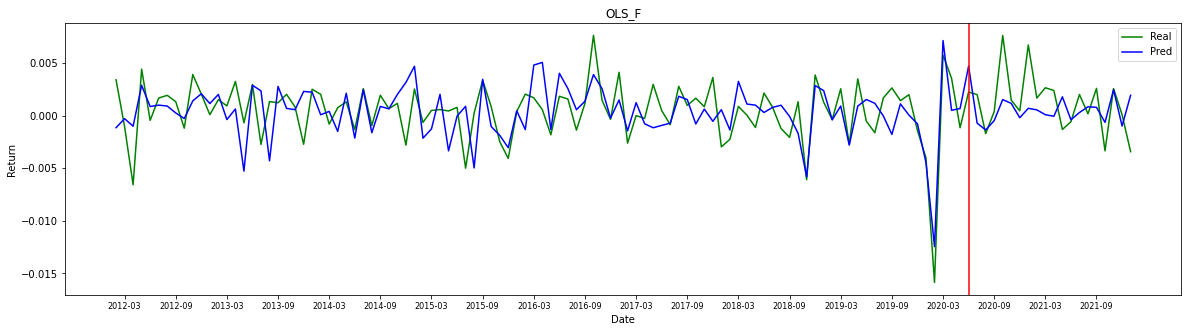

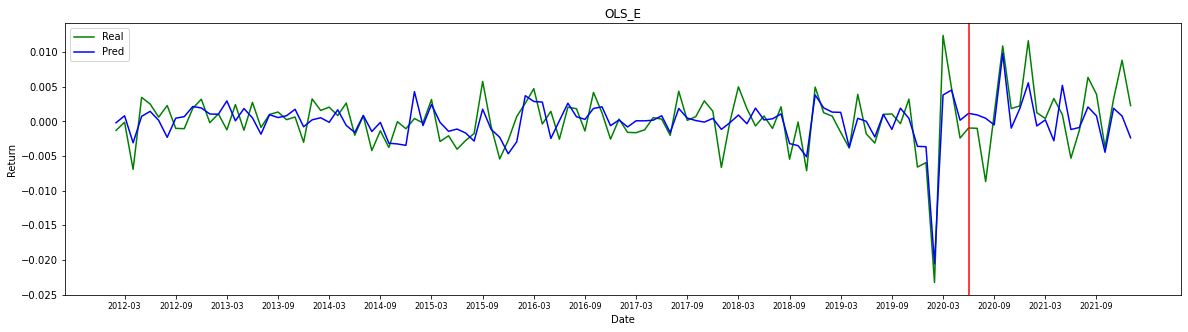

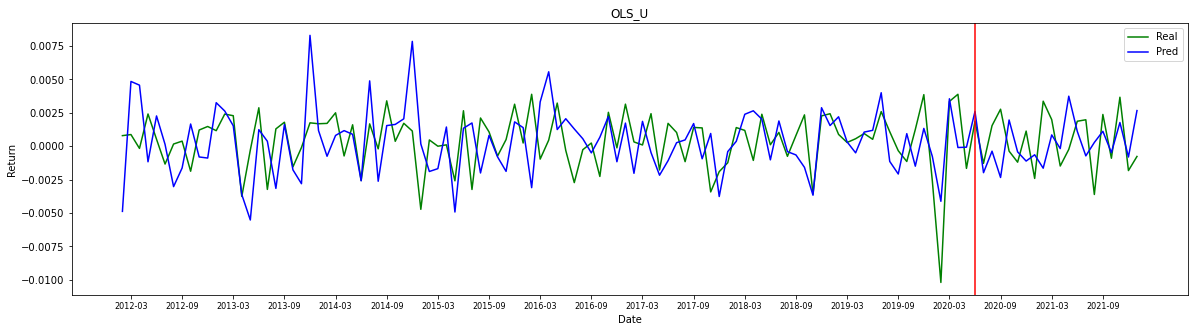

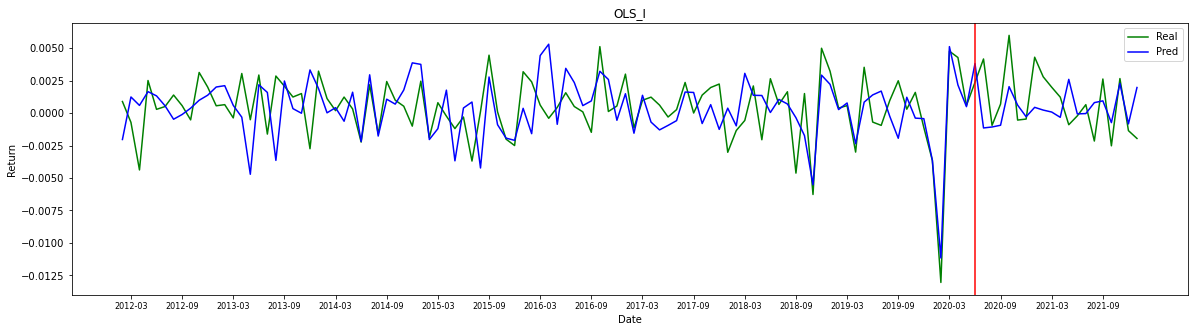

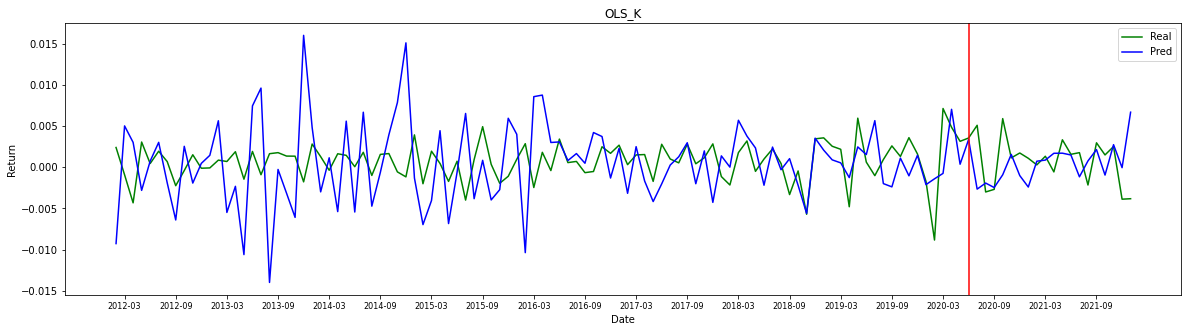

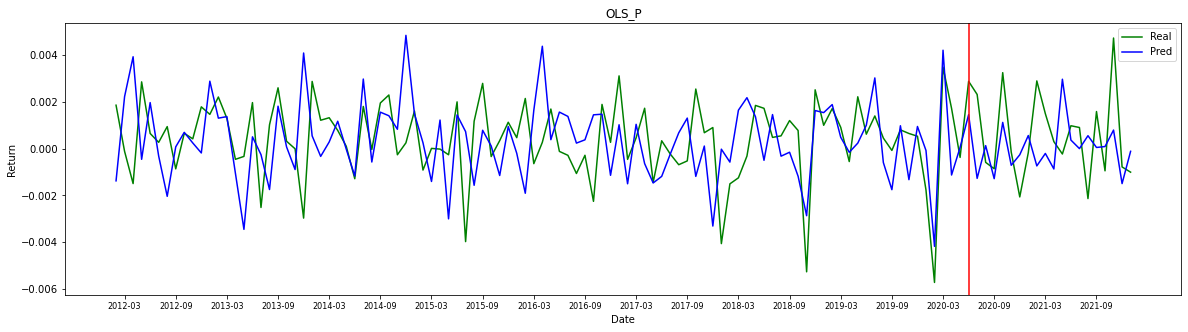

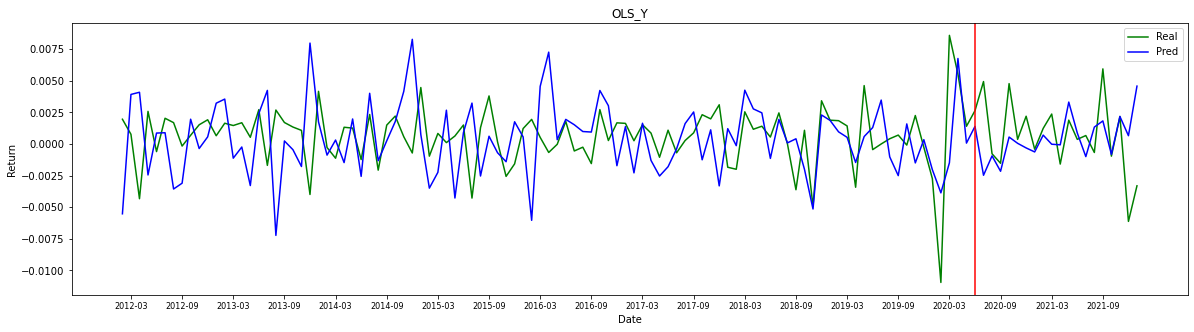

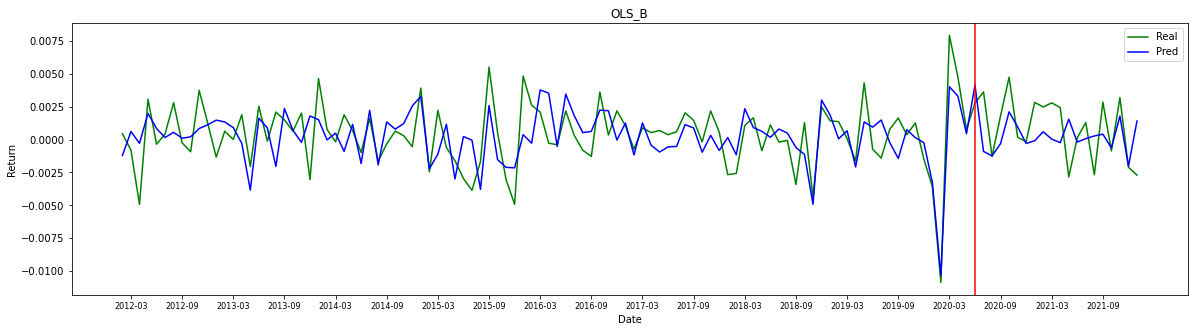

In [553]:
list_2 = (['RET_F','ret_F'],['RET_E','ret_E'],['RET_U','ret_U'],['RET_I','ret_I'],['RET_K','ret_K'],['RET_P','ret_P'],['RET_Y','ret_Y'],['RET_B','ret_B'])

for i in list_2:
    plt.figure(figsize=(20, 5))
    plt.plot(df_ols[i[0]],color='g')
    plt.plot(df_ols[i[1]],color='b')
    plt.xticks(range(1,120,6),pd.date_range('2012-03','2022-02',freq='6M').strftime("%Y-%m").tolist(),fontsize=8)
    plt.axvline(x=100, color='r')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(['Real','Pred'])
    plt.title('OLS_'+i[0][-1])

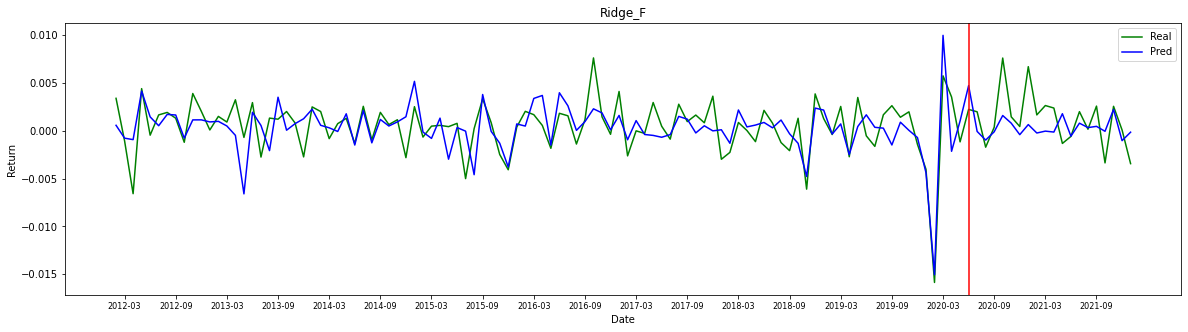

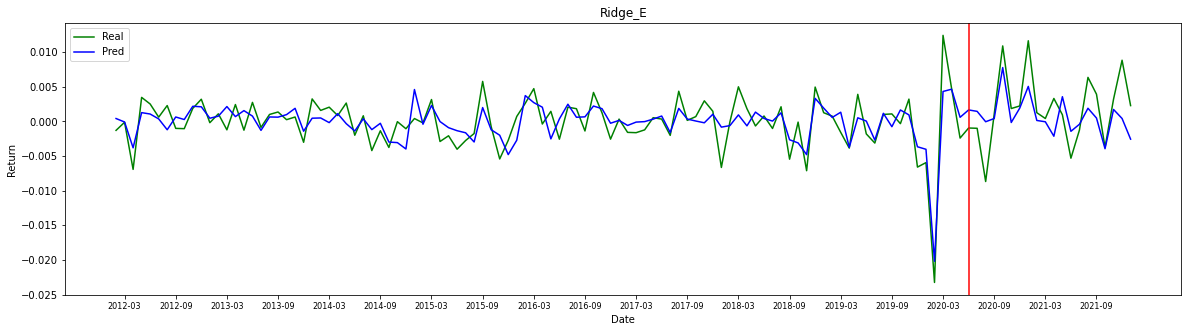

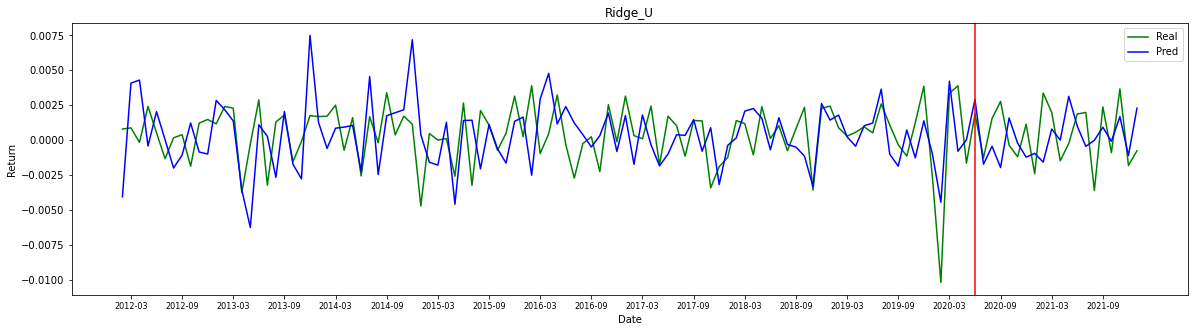

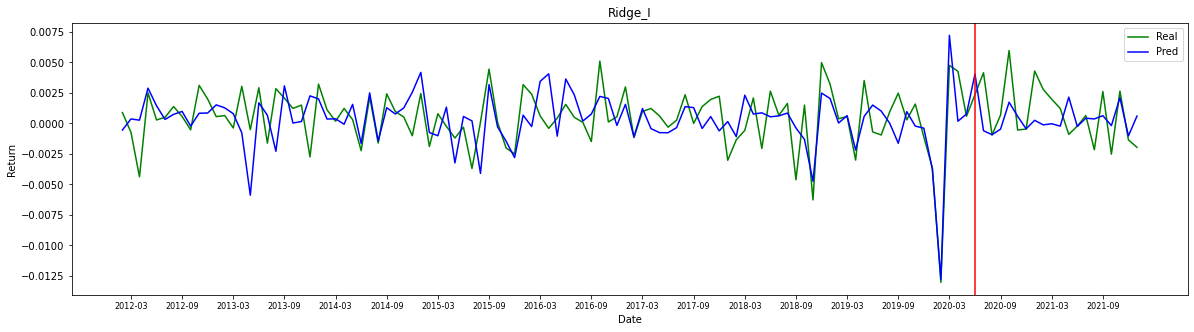

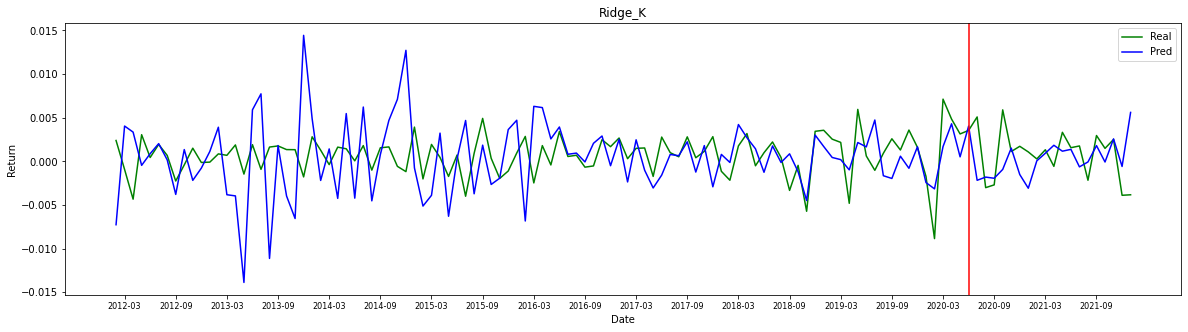

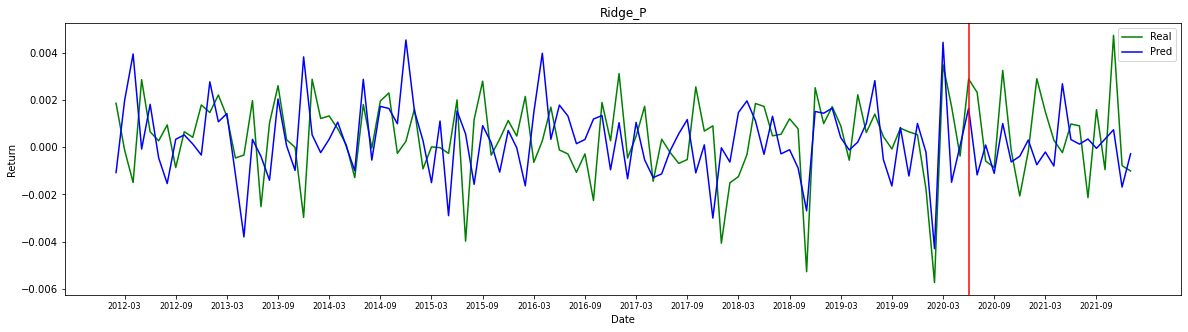

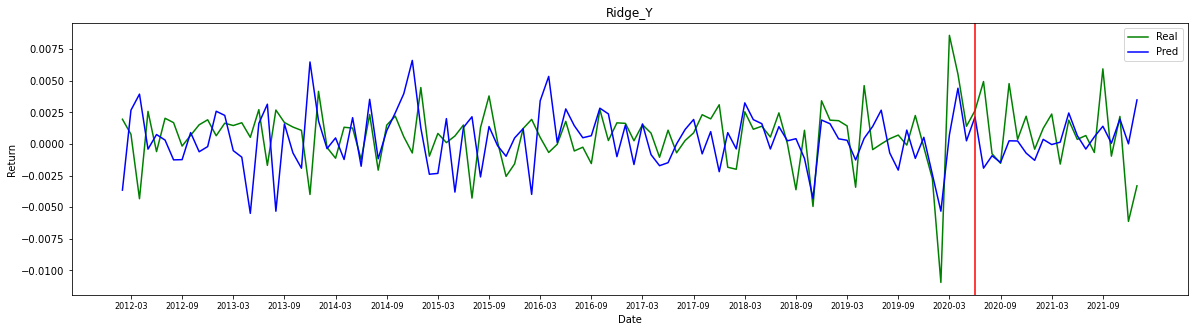

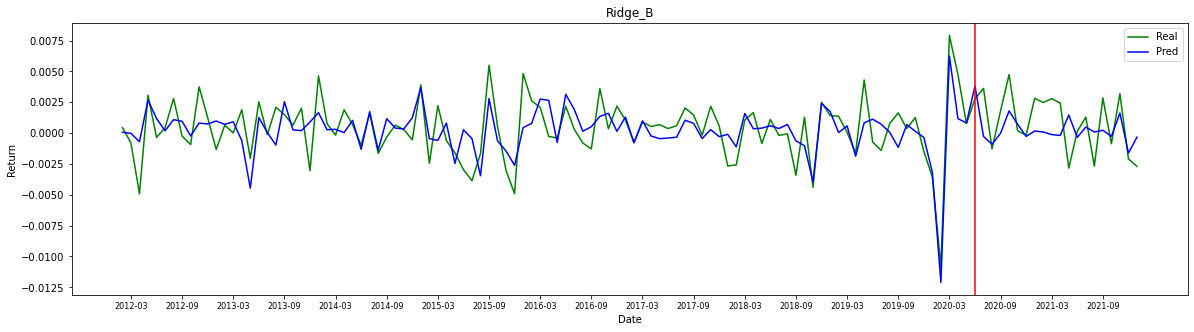

In [554]:
for i in list_2:
    plt.figure(figsize=(20, 5))
    plt.plot(df_ridge[i[0]],color='g')
    plt.plot(df_ridge[i[1]],color='b')
    plt.xticks(range(1,120,6),pd.date_range('2012-03','2022-02',freq='6M').strftime("%Y-%m").tolist(),fontsize=8)
    plt.axvline(x=100, color='r')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(['Real','Pred'])
    plt.title('Ridge_'+i[0][-1])

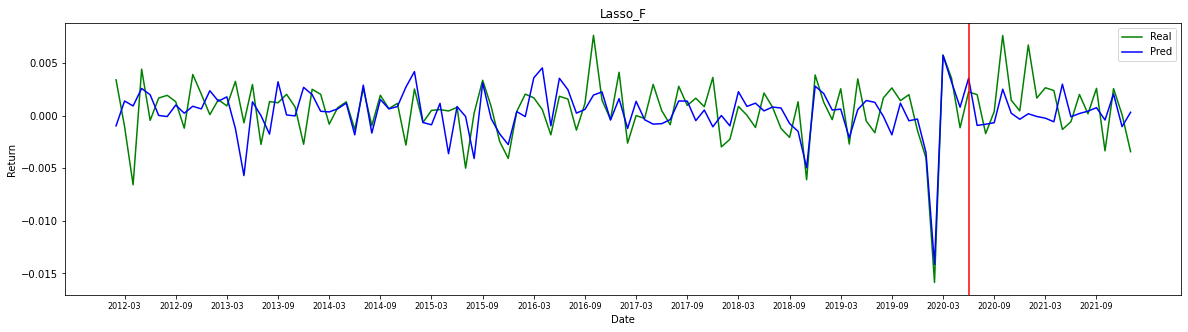

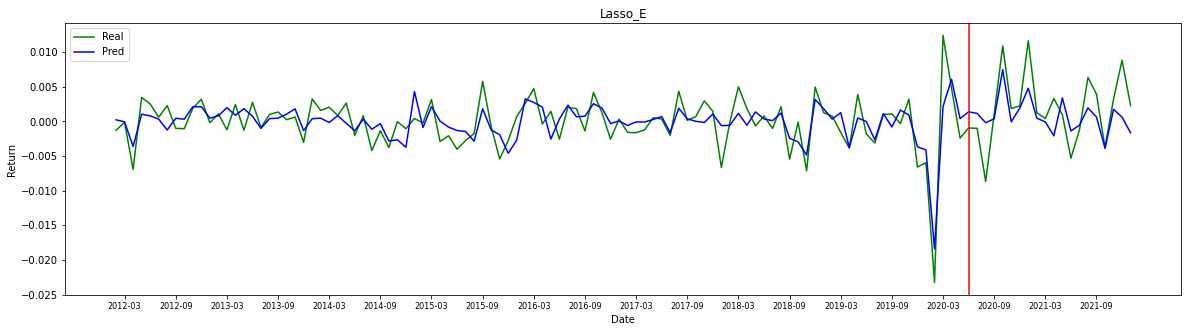

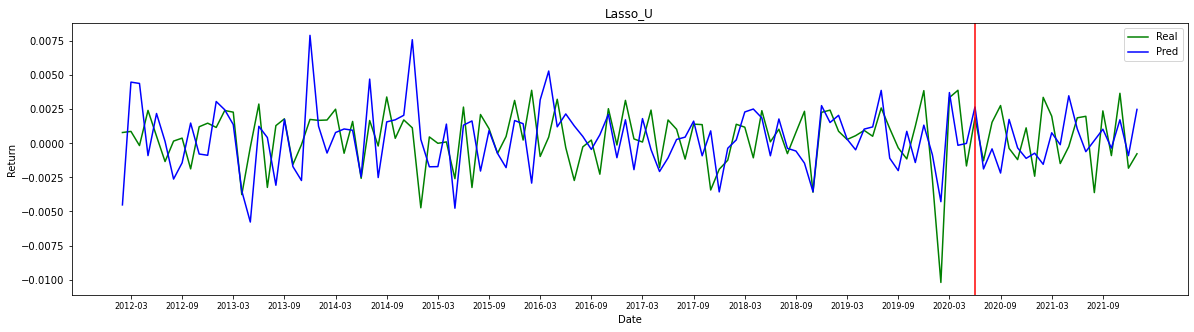

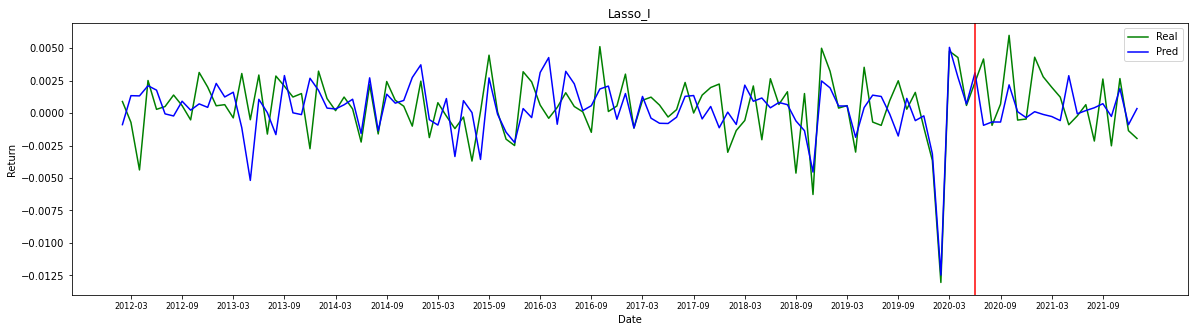

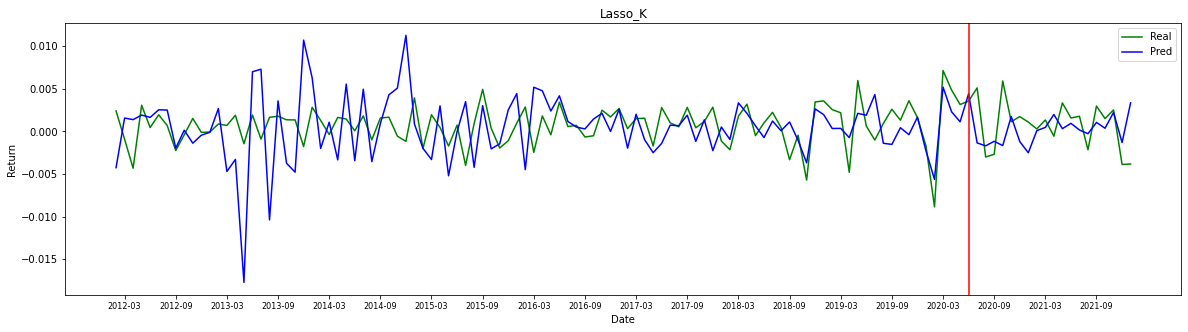

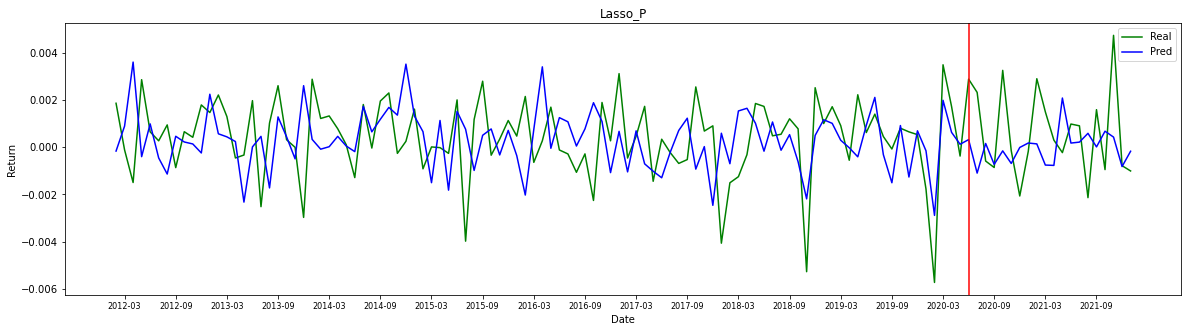

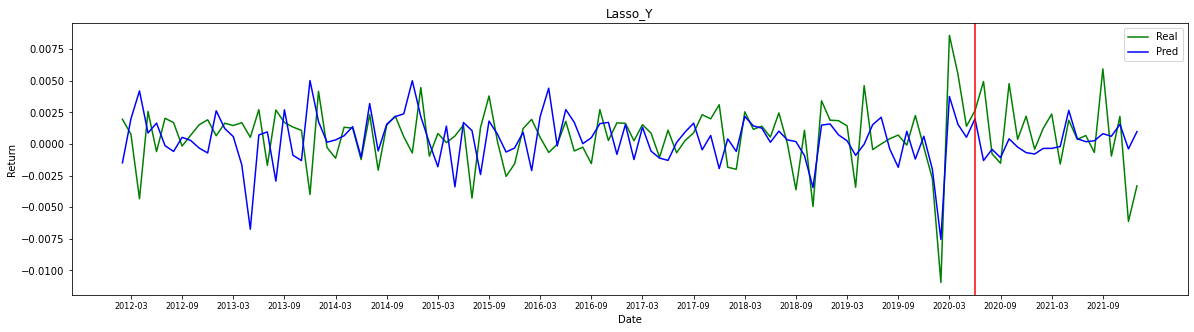

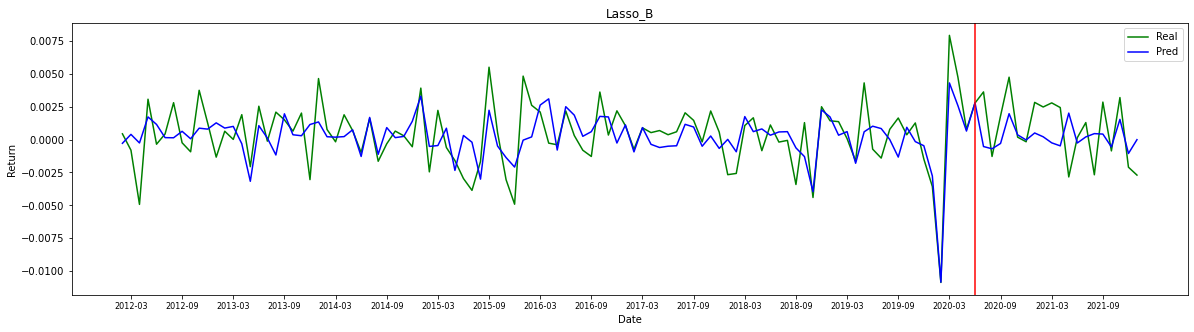

In [555]:
for i in list_2:
    plt.figure(figsize=(20, 5))
    plt.plot(df_lasso[i[0]],color='g')
    plt.plot(df_lasso[i[1]],color='b')
    plt.xticks(range(1,120,6),pd.date_range('2012-03','2022-02',freq='6M').strftime("%Y-%m").tolist(),fontsize=8)
    plt.axvline(x=100, color='r')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(['Real','Pred'])
    plt.title('Lasso_'+i[0][-1])

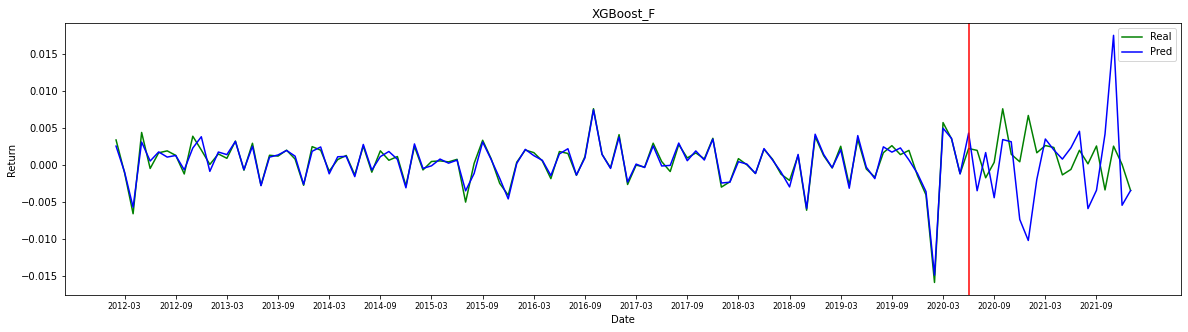

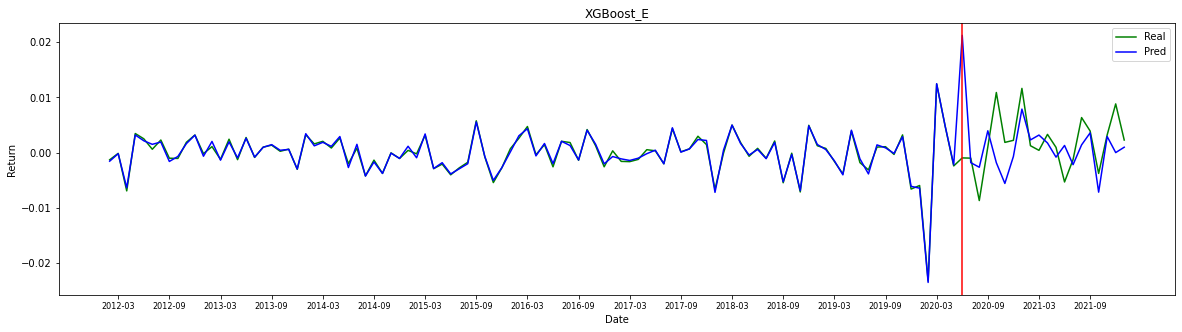

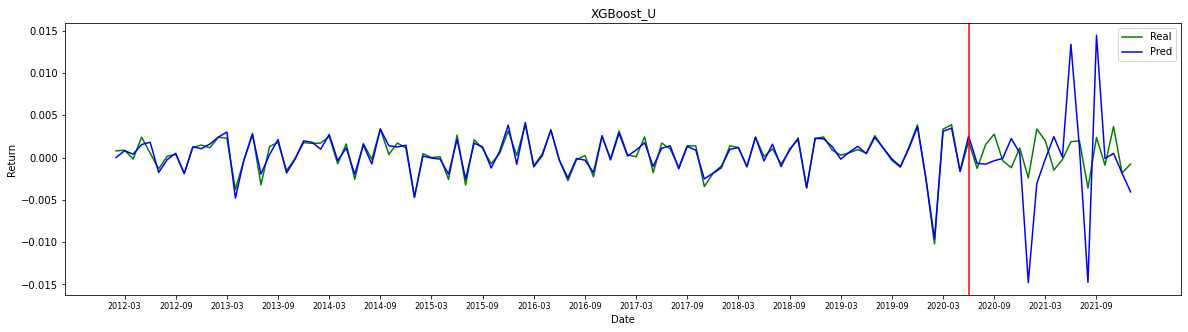

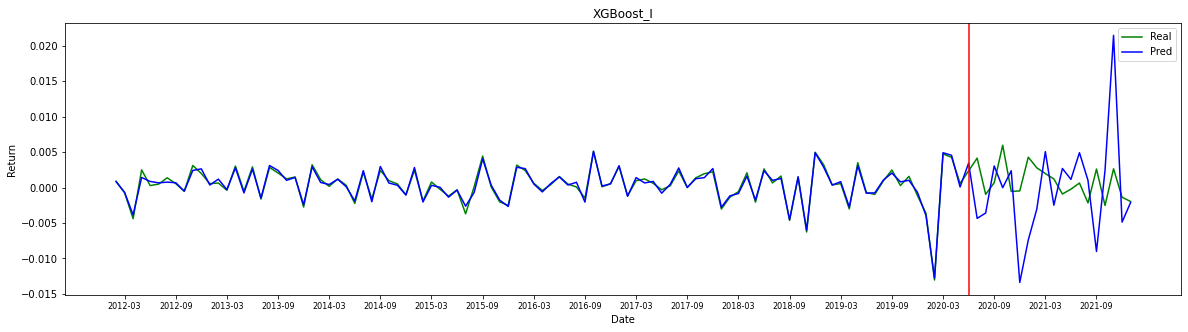

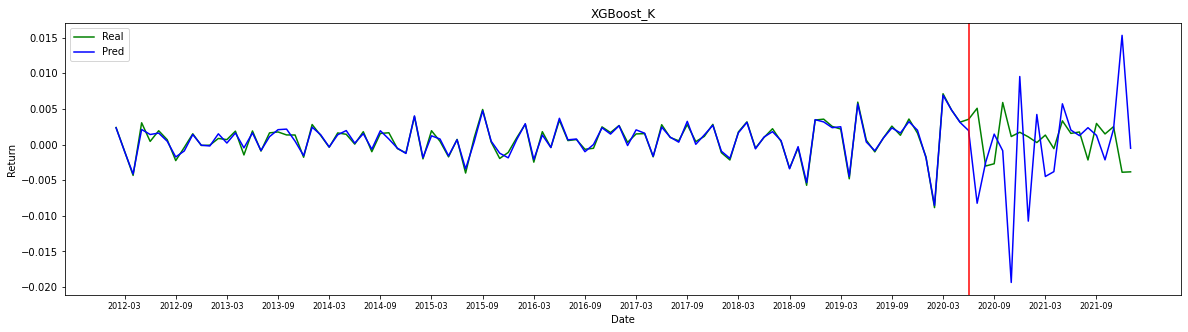

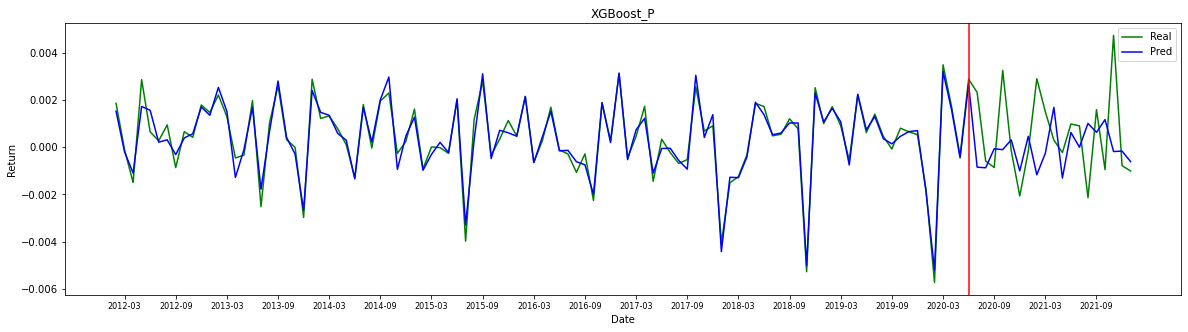

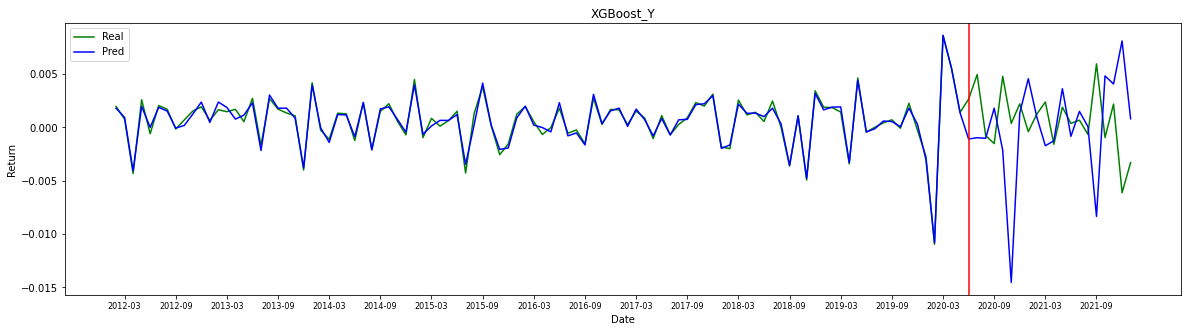

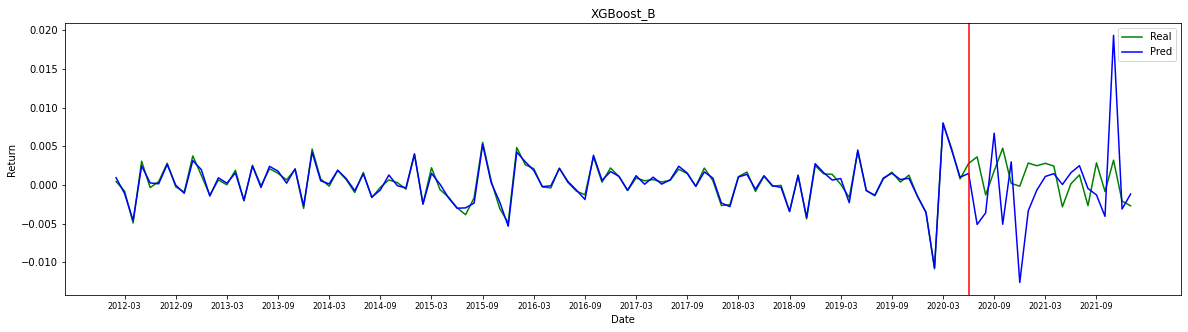

In [556]:
for i in list_2:
    plt.figure(figsize=(20, 5))
    plt.plot(df_xg[i[0]],color='g')
    plt.plot(df_xg[i[1]],color='b')
    plt.xticks(range(1,120,6),pd.date_range('2012-03','2022-02',freq='6M').strftime("%Y-%m").tolist(),fontsize=8)
    plt.axvline(x=100, color='r')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(['Real','Pred'])
    plt.title('XGBoost_'+i[0][-1])

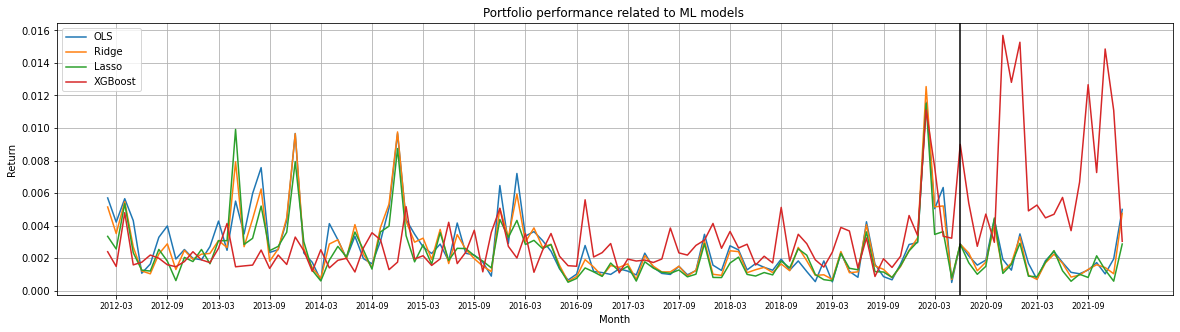

In [557]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.figure(figsize=(20, 5))
plt.title('Portfolio performance related to ML models ')
plt.plot(df_ols['Portfolio Return'],label='OLS')
plt.plot(df_ridge['Portfolio Return'],label='Ridge')
plt.plot(df_lasso['Portfolio Return'],label='Lasso')
plt.plot(df_xg['Portfolio Return'],label='XGBoost')
plt.axvline(x=100, color='black')
plt.xticks(range(1,120,6),pd.date_range('2012-03','2022-02',freq='6M').strftime("%Y-%m").tolist(),fontsize=8)
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid()
plt.legend()
plt.show()

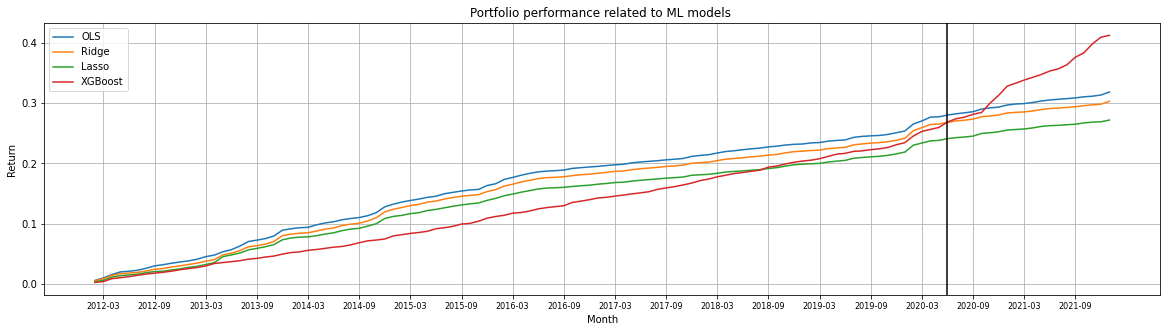

In [558]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.figure(figsize=(20, 5))
plt.title('Portfolio performance related to ML models ')
plt.plot(df_ols['Portfolio Return'].cumsum(),label='OLS')
plt.plot(df_ridge['Portfolio Return'].cumsum(),label='Ridge')
plt.plot(df_lasso['Portfolio Return'].cumsum(),label='Lasso')
plt.plot(df_xg['Portfolio Return'].cumsum(),label='XGBoost')
plt.axvline(x=100, color='black')
plt.xticks(range(1,120,6),pd.date_range('2012-03','2022-02',freq='6M').strftime("%Y-%m").tolist(),fontsize=8)
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid()
plt.legend()
plt.show()

## Average Monthly Turnover

### (1)OLS

In [559]:
F = 0
E = 0
U = 0
I = 0
K = 0
P = 0
Y = 0
B = 0
turn_over_1 = 0
turn_over_2 = 0

for i in range(len(df_ols)-1):
    if i <100:
        F = df_ols['w_F'][i]*df_ols['RET_F'][i+1] 
        E = df_ols['w_E'][i]*df_ols['RET_E'][i+1] 
        U = df_ols['w_U'][i]*df_ols['RET_U'][i+1] 
        I = df_ols['w_I'][i]*df_ols['RET_I'][i+1]
        K = df_ols['w_K'][i]*df_ols['RET_K'][i+1] 
        P = df_ols['w_P'][i]*df_ols['RET_P'][i+1] 
        Y = df_ols['w_Y'][i]*df_ols['RET_Y'][i+1] 
        B = df_ols['w_B'][i]*df_ols['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_1 += np.abs(df_ols['w_F'][i+1] - (df_ols['w_F'][i]*(1+df_ols['ret_F'][i+1]))/(1+J))+np.abs(df_ols['w_E'][i+1] - (df_ols['w_E'][i]*(1+df_ols['ret_E'][i+1]))/(1+J))+np.abs(df_ols['w_U'][i+1] - (df_ols['w_U'][i]*(1+df_ols['ret_U'][i+1]))/(1+J))+np.abs(df_ols['w_I'][i+1] - (df_ols['w_I'][i]*(1+df_ols['ret_I'][i+1]))/(1+J))+np.abs(df_ols['w_K'][i+1] - (df_ols['w_K'][i]*(1+df_ols['ret_K'][i+1]))/(1+J))+np.abs(df_ols['w_P'][i+1] - (df_ols['w_P'][i]*(1+df_ols['ret_P'][i+1]))/(1+J))+np.abs(df_ols['w_Y'][i+1] - (df_ols['w_Y'][i]*(1+df_ols['ret_Y'][i+1]))/(1+J))+np.abs(df_ols['w_B'][i+1] - (df_ols['w_B'][i]*(1+df_ols['ret_B'][i+1]))/(1+J))

    else:
        F = df_ols['w_F'][i]*df_ols['RET_F'][i+1] 
        E = df_ols['w_E'][i]*df_ols['RET_E'][i+1] 
        U = df_ols['w_U'][i]*df_ols['RET_U'][i+1] 
        I = df_ols['w_I'][i]*df_ols['RET_I'][i+1]
        K = df_ols['w_K'][i]*df_ols['RET_K'][i+1] 
        P = df_ols['w_P'][i]*df_ols['RET_P'][i+1] 
        Y = df_ols['w_Y'][i]*df_ols['RET_Y'][i+1] 
        B = df_ols['w_B'][i]*df_ols['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_2 += np.abs(df_ols['w_F'][i+1] - (df_ols['w_F'][i]*(1+df_ols['ret_F'][i+1]))/(1+J))+np.abs(df_ols['w_E'][i+1] - (df_ols['w_E'][i]*(1+df_ols['ret_E'][i+1]))/(1+J))+np.abs(df_ols['w_U'][i+1] - (df_ols['w_U'][i]*(1+df_ols['ret_U'][i+1]))/(1+J))+np.abs(df_ols['w_I'][i+1] - (df_ols['w_I'][i]*(1+df_ols['ret_I'][i+1]))/(1+J))+np.abs(df_ols['w_K'][i+1] - (df_ols['w_K'][i]*(1+df_ols['ret_K'][i+1]))/(1+J))+np.abs(df_ols['w_P'][i+1] - (df_ols['w_P'][i]*(1+df_ols['ret_P'][i+1]))/(1+J))+np.abs(df_ols['w_Y'][i+1] - (df_ols['w_Y'][i]*(1+df_ols['ret_Y'][i+1]))/(1+J))+np.abs(df_ols['w_B'][i+1] - (df_ols['w_B'][i]*(1+df_ols['ret_B'][i+1]))/(1+J))

print('The in sample average monthly turnover:', (1/100) * turn_over_1)
print('The out of sample average monthly turnover:', (1/20) * turn_over_2)

The in sample average monthly turnover: 2.596429399837491
The out of sample average monthly turnover: 2.3350937445295394


### (2)Ridge

In [560]:
F = 0
E = 0
U = 0
I = 0
K = 0
P = 0
Y = 0
B = 0
turn_over_1 = 0
turn_over_2 = 0

for i in range(len(df_ridge)-1):
    if i <100:
        F = df_ridge['w_F'][i]*df_ridge['RET_F'][i+1] 
        E = df_ridge['w_E'][i]*df_ridge['RET_E'][i+1] 
        U = df_ridge['w_U'][i]*df_ridge['RET_U'][i+1] 
        I = df_ridge['w_I'][i]*df_ridge['RET_I'][i+1]
        K = df_ridge['w_K'][i]*df_ridge['RET_K'][i+1] 
        P = df_ridge['w_P'][i]*df_ridge['RET_P'][i+1] 
        Y = df_ridge['w_Y'][i]*df_ridge['RET_Y'][i+1] 
        B = df_ridge['w_B'][i]*df_ridge['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_1 += np.abs(df_ridge['w_F'][i+1] - (df_ridge['w_F'][i]*(1+df_ridge['ret_F'][i+1]))/(1+J))+np.abs(df_ridge['w_E'][i+1] - (df_ridge['w_E'][i]*(1+df_ridge['ret_E'][i+1]))/(1+J))+np.abs(df_ridge['w_U'][i+1] - (df_ridge['w_U'][i]*(1+df_ridge['ret_U'][i+1]))/(1+J))+np.abs(df_ridge['w_I'][i+1] - (df_ridge['w_I'][i]*(1+df_ridge['ret_I'][i+1]))/(1+J))+np.abs(df_ridge['w_K'][i+1] - (df_ridge['w_K'][i]*(1+df_ridge['ret_K'][i+1]))/(1+J))+np.abs(df_ridge['w_P'][i+1] - (df_ridge['w_P'][i]*(1+df_ridge['ret_P'][i+1]))/(1+J))+np.abs(df_ridge['w_Y'][i+1] - (df_ridge['w_Y'][i]*(1+df_ridge['ret_Y'][i+1]))/(1+J))+np.abs(df_ridge['w_B'][i+1] - (df_ridge['w_B'][i]*(1+df_ridge['ret_B'][i+1]))/(1+J))

    else:
        F = df_ridge['w_F'][i]*df_ridge['RET_F'][i+1] 
        E = df_ridge['w_E'][i]*df_ridge['RET_E'][i+1] 
        U = df_ridge['w_U'][i]*df_ridge['RET_U'][i+1] 
        I = df_ridge['w_I'][i]*df_ridge['RET_I'][i+1]
        K = df_ridge['w_K'][i]*df_ridge['RET_K'][i+1] 
        P = df_ridge['w_P'][i]*df_ridge['RET_P'][i+1] 
        Y = df_ridge['w_Y'][i]*df_ridge['RET_Y'][i+1] 
        B = df_ridge['w_B'][i]*df_ridge['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_2 += np.abs(df_ridge['w_F'][i+1] - (df_ridge['w_F'][i]*(1+df_ridge['ret_F'][i+1]))/(1+J))+np.abs(df_ridge['w_E'][i+1] - (df_ridge['w_E'][i]*(1+df_ridge['ret_E'][i+1]))/(1+J))+np.abs(df_ridge['w_U'][i+1] - (df_ridge['w_U'][i]*(1+df_ridge['ret_U'][i+1]))/(1+J))+np.abs(df_ridge['w_I'][i+1] - (df_ridge['w_I'][i]*(1+df_ridge['ret_I'][i+1]))/(1+J))+np.abs(df_ridge['w_K'][i+1] - (df_ridge['w_K'][i]*(1+df_ridge['ret_K'][i+1]))/(1+J))+np.abs(df_ridge['w_P'][i+1] - (df_ridge['w_P'][i]*(1+df_ridge['ret_P'][i+1]))/(1+J))+np.abs(df_ridge['w_Y'][i+1] - (df_ridge['w_Y'][i]*(1+df_ridge['ret_Y'][i+1]))/(1+J))+np.abs(df_ridge['w_B'][i+1] - (df_ridge['w_B'][i]*(1+df_ridge['ret_B'][i+1]))/(1+J))

print('The in sample average monthly turnover:', (1/100) * turn_over_1)
print('The out of sample average monthly turnover:', (1/20) * turn_over_2)

The in sample average monthly turnover: 2.3160804868458205
The out of sample average monthly turnover: 1.8678235191389085


### (3)Lasso

In [561]:
F = 0
E = 0
U = 0
I = 0
K = 0
P = 0
Y = 0
B = 0
turn_over_1 = 0
turn_over_2 = 0

for i in range(len(df_lasso)-1):
    if i <100:
        F = df_lasso['w_F'][i]*df_lasso['RET_F'][i+1] 
        E = df_lasso['w_E'][i]*df_lasso['RET_E'][i+1] 
        U = df_lasso['w_U'][i]*df_lasso['RET_U'][i+1] 
        I = df_lasso['w_I'][i]*df_lasso['RET_I'][i+1]
        K = df_lasso['w_K'][i]*df_lasso['RET_K'][i+1] 
        P = df_lasso['w_P'][i]*df_lasso['RET_P'][i+1] 
        Y = df_lasso['w_Y'][i]*df_lasso['RET_Y'][i+1] 
        B = df_lasso['w_B'][i]*df_lasso['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_1 += np.abs(df_lasso['w_F'][i+1] - (df_lasso['w_F'][i]*(1+df_lasso['ret_F'][i+1]))/(1+J))+np.abs(df_lasso['w_E'][i+1] - (df_lasso['w_E'][i]*(1+df_lasso['ret_E'][i+1]))/(1+J))+np.abs(df_lasso['w_U'][i+1] - (df_lasso['w_U'][i]*(1+df_lasso['ret_U'][i+1]))/(1+J))+np.abs(df_lasso['w_I'][i+1] - (df_lasso['w_I'][i]*(1+df_lasso['ret_I'][i+1]))/(1+J))+np.abs(df_lasso['w_K'][i+1] - (df_lasso['w_K'][i]*(1+df_lasso['ret_K'][i+1]))/(1+J))+np.abs(df_lasso['w_P'][i+1] - (df_lasso['w_P'][i]*(1+df_lasso['ret_P'][i+1]))/(1+J))+np.abs(df_lasso['w_Y'][i+1] - (df_lasso['w_Y'][i]*(1+df_lasso['ret_Y'][i+1]))/(1+J))+np.abs(df_lasso['w_B'][i+1] - (df_lasso['w_B'][i]*(1+df_lasso['ret_B'][i+1]))/(1+J))

    else:
        F = df_lasso['w_F'][i]*df_lasso['RET_F'][i+1] 
        E = df_lasso['w_E'][i]*df_lasso['RET_E'][i+1] 
        U = df_lasso['w_U'][i]*df_lasso['RET_U'][i+1] 
        I = df_lasso['w_I'][i]*df_lasso['RET_I'][i+1]
        K = df_lasso['w_K'][i]*df_lasso['RET_K'][i+1] 
        P = df_lasso['w_P'][i]*df_lasso['RET_P'][i+1] 
        Y = df_lasso['w_Y'][i]*df_lasso['RET_Y'][i+1] 
        B = df_lasso['w_B'][i]*df_lasso['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_2 += np.abs(df_lasso['w_F'][i+1] - (df_lasso['w_F'][i]*(1+df_lasso['ret_F'][i+1]))/(1+J))+np.abs(df_lasso['w_E'][i+1] - (df_lasso['w_E'][i]*(1+df_lasso['ret_E'][i+1]))/(1+J))+np.abs(df_lasso['w_U'][i+1] - (df_lasso['w_U'][i]*(1+df_lasso['ret_U'][i+1]))/(1+J))+np.abs(df_lasso['w_I'][i+1] - (df_lasso['w_I'][i]*(1+df_lasso['ret_I'][i+1]))/(1+J))+np.abs(df_lasso['w_K'][i+1] - (df_lasso['w_K'][i]*(1+df_lasso['ret_K'][i+1]))/(1+J))+np.abs(df_lasso['w_P'][i+1] - (df_lasso['w_P'][i]*(1+df_lasso['ret_P'][i+1]))/(1+J))+np.abs(df_lasso['w_Y'][i+1] - (df_lasso['w_Y'][i]*(1+df_lasso['ret_Y'][i+1]))/(1+J))+np.abs(df_lasso['w_B'][i+1] - (df_lasso['w_B'][i]*(1+df_lasso['ret_B'][i+1]))/(1+J))

print('The in sample average monthly turnover:', (1/100) * turn_over_1)
print('The out of sample average monthly turnover:', (1/20) * turn_over_2)

The in sample average monthly turnover: 2.1991958247345047
The out of sample average monthly turnover: 1.8344228218516379


### (4)XGBoost

In [564]:
F = 0
E = 0
U = 0
I = 0
K = 0
P = 0
Y = 0
B = 0
turn_over_1 = 0
turn_over_2 = 0

for i in range(len(df_xg)-1):
    if i <100:
        F = df_xg['w_F'][i]*df_xg['RET_F'][i+1] 
        E = df_xg['w_E'][i]*df_xg['RET_E'][i+1] 
        U = df_xg['w_U'][i]*df_xg['RET_U'][i+1] 
        I = df_xg['w_I'][i]*df_xg['RET_I'][i+1]
        K = df_xg['w_K'][i]*df_xg['RET_K'][i+1] 
        P = df_xg['w_P'][i]*df_xg['RET_P'][i+1] 
        Y = df_xg['w_Y'][i]*df_xg['RET_Y'][i+1] 
        B = df_xg['w_B'][i]*df_xg['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_1 += np.abs(df_xg['w_F'][i+1] - (df_xg['w_F'][i]*(1+df_xg['ret_F'][i+1]))/(1+J))+np.abs(df_xg['w_E'][i+1] - (df_xg['w_E'][i]*(1+df_xg['ret_E'][i+1]))/(1+J))+np.abs(df_xg['w_U'][i+1] - (df_xg['w_U'][i]*(1+df_xg['ret_U'][i+1]))/(1+J))+np.abs(df_xg['w_I'][i+1] - (df_xg['w_I'][i]*(1+df_xg['ret_I'][i+1]))/(1+J))+np.abs(df_xg['w_K'][i+1] - (df_xg['w_K'][i]*(1+df_xg['ret_K'][i+1]))/(1+J))+np.abs(df_xg['w_P'][i+1] - (df_xg['w_P'][i]*(1+df_xg['ret_P'][i+1]))/(1+J))+np.abs(df_xg['w_Y'][i+1] - (df_xg['w_Y'][i]*(1+df_xg['ret_Y'][i+1]))/(1+J))+np.abs(df_xg['w_B'][i+1] - (df_xg['w_B'][i]*(1+df_xg['ret_B'][i+1]))/(1+J))

    else:
        F = df_xg['w_F'][i]*df_xg['RET_F'][i+1] 
        E = df_xg['w_E'][i]*df_xg['RET_E'][i+1] 
        U = df_xg['w_U'][i]*df_xg['RET_U'][i+1] 
        I = df_xg['w_I'][i]*df_xg['RET_I'][i+1]
        K = df_xg['w_K'][i]*df_xg['RET_K'][i+1] 
        P = df_xg['w_P'][i]*df_xg['RET_P'][i+1] 
        Y = df_xg['w_Y'][i]*df_xg['RET_Y'][i+1] 
        B = df_xg['w_B'][i]*df_xg['RET_B'][i+1]
        J = F+E+U+I+K+P+Y+B
    
        turn_over_2 += np.abs(df_xg['w_F'][i+1] - (df_xg['w_F'][i]*(1+df_xg['ret_F'][i+1]))/(1+J))+np.abs(df_xg['w_E'][i+1] - (df_xg['w_E'][i]*(1+df_xg['ret_E'][i+1]))/(1+J))+np.abs(df_xg['w_U'][i+1] - (df_xg['w_U'][i]*(1+df_xg['ret_U'][i+1]))/(1+J))+np.abs(df_xg['w_I'][i+1] - (df_xg['w_I'][i]*(1+df_xg['ret_I'][i+1]))/(1+J))+np.abs(df_xg['w_K'][i+1] - (df_xg['w_K'][i]*(1+df_xg['ret_K'][i+1]))/(1+J))+np.abs(df_xg['w_P'][i+1] - (df_xg['w_P'][i]*(1+df_xg['ret_P'][i+1]))/(1+J))+np.abs(df_xg['w_Y'][i+1] - (df_xg['w_Y'][i]*(1+df_xg['ret_Y'][i+1]))/(1+J))+np.abs(df_xg['w_B'][i+1] - (df_xg['w_B'][i]*(1+df_xg['ret_B'][i+1]))/(1+J))

print('The in sample average monthly turnover:', (1/100) * turn_over_1)
print('The out of sample average monthly turnover:', (1/20) * turn_over_2)

The in sample average monthly turnover: 2.282856275336788
The out of sample average monthly turnover: 2.169228791120941
